In [1]:
import time, os
import torch
import numpy as np
import torch.nn as nn

import pandas as pd
from tqdm import tqdm

import json
import pickle

In [2]:
def load_json(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    return data

In [3]:
# Dataset sizes
ds_sizes = {}
_propfile = "../data_generator/properties_v0/test_hard_neg.json"
df = pd.read_json(_propfile, orient="index")
for prop in range(9):
    ndf = df[df['prop']==(prop+1)].drop_duplicates()
    ds_sizes[prop] = len(ndf)
    print(prop, len(ndf))

0 1435
1 7658
2 8273
3 6522
4 7658
5 8273
6 6522
7 33160
8 31746


# Gather results

In [4]:
def create_table_results(itype, models,props=9 ):
    bigtable = []
    _props = 9
    for _prop in range(props):
        for _model in _models:
            _ifile = os.path.join(basepath,'results_{input_type}_p{prop}_{model}.json'.format(input_type=itype,
                                                                                                   prop=_prop,
                                                                                                   model=_model.replace('/','_')))
            df = pd.read_json(load_json(_ifile), orient="index")
            bigtable.append(df)
    bigdf = pd.concat(bigtable)
    return bigdf


def get_last_layers(bigdf):

    # Filter only last layer for each model
    maxlayer_dict = {}
    for (idx,row) in bigdf.groupby(['model']).max()['layer'].iteritems():
        maxlayer_dict[idx] = row


    last_layers = []
    for mod,lay in maxlayer_dict.items():
        last_layers.append(bigdf[(bigdf['model']==mod) & (bigdf['layer']==lay)])

    lastlayer_df = pd.concat(last_layers)
    return lastlayer_df


def get_top_by_prop(df,prop, method):
    pdf =df[df['prop'] == prop]
    lmethod = [method,method+"_l1",method+"_l2",method+"_l3"]
    if method=='avg':
        lmethod[0] = 'avg_a'
        method='avg_a'
    return pdf.sort_values(method, ascending=False).groupby(['model']).head(1).sort_values(method,ascending=False)[['input','model','prop','layer',*lmethod]]

def get_last_by_prop(df,prop):
    pdf =df[df['prop'] == prop]
    #return pdf.sort_values(method,ascending=False)[['input','model','prop','layer',method]]
    return pdf

In [5]:
basepath = '../output/computed_results'
_dataset_base = "/users/cost/jlovonme/data"
_inputtype = 'concept' # name or concept
#_methods = ['cls','avg_all']
_methods = ['cls','avg_a','cls_l1','avg_l1','cls_l2','avg_l2','cls_l3','avg_l3','ecls','eavg','ecls_l1','eavg_l1','ecls_l2','eavg_l2','ecls_l3','eavg_l3']
_models = ['ft-cc','ft-wiki','bert-base-cased','bert-large-cased','roberta-base','roberta-large','sentence-transformers/all-mpnet-base-v2',
          'allenai/scibert_scivocab_cased','ctp','ernie-base','sentence-transformers/bert-base-nli-mean-tokens','sentence-transformers/all-distilroberta-v1']
#_models = ['bert-base-cased']
orderedmethod = ['cls','cls_l1','cls_l2','cls_l3','avg_a','avg_l1','avg_l2','avg_l3','ecls','ecls_l1','ecls_l2','ecls_l3','eavg','eavg_l1','eavg_l2','eavg_l3']

# Updated 30/01 - Script to obtain L2 results

In [6]:
_bigdf = create_table_results('concept', _models,props=9 )
_lastlayers = get_last_layers(_bigdf)

for p in range(9):
    for method in ['cls','avg']:
        print("Property",p, method)
        display(get_top_by_prop(_bigdf,p, method))

Property 0 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
12,concept,sentence-transformers/all-mpnet-base-v2,0,12,83.21,79.72,83.00,82.86
6,concept,sentence-transformers/all-distilroberta-v1,0,6,83.14,57.49,80.98,79.37
11,concept,bert-large-cased,0,11,81.25,57.56,80.14,78.05
0,concept,ft-wiki,0,0,79.65,64.95,73.17,69.62
4,concept,sentence-transformers/bert-base-nli-mean-tokens,0,4,78.82,55.40,76.72,74.15
4,concept,ernie-base,0,4,75.26,56.79,74.22,72.13
12,concept,bert-base-cased,0,12,72.61,54.70,67.60,64.74
2,concept,allenai/scibert_scivocab_cased,0,2,71.92,54.98,69.13,66.62
12,concept,roberta-base,0,12,65.99,53.94,56.38,54.91
5,concept,ctp,0,5,63.69,51.92,61.46,58.68


Property 0 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
11,concept,sentence-transformers/all-mpnet-base-v2,0,11,86.20,69.48,85.02,83.14
6,concept,sentence-transformers/all-distilroberta-v1,0,6,85.16,57.14,83.28,80.07
1,concept,bert-large-cased,0,1,82.58,65.02,80.49,77.42
1,concept,allenai/scibert_scivocab_cased,0,1,80.42,59.30,76.59,73.38
1,concept,bert-base-cased,0,1,80.00,61.74,77.84,74.91
1,concept,ernie-base,0,1,79.86,63.07,77.77,74.77
0,concept,ft-wiki,0,0,79.65,64.95,73.17,69.62
3,concept,sentence-transformers/bert-base-nli-mean-tokens,0,3,79.30,60.35,76.10,73.31
10,concept,ctp,0,10,77.42,55.05,70.31,65.78
12,concept,roberta-base,0,12,76.38,60.56,69.13,65.23


Property 1 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
12,concept,sentence-transformers/all-mpnet-base-v2,1,12,72.04,67.71,71.57,71.00
6,concept,sentence-transformers/all-distilroberta-v1,1,6,68.62,48.02,66.45,63.40
12,concept,sentence-transformers/bert-base-nli-mean-tokens,1,12,52.18,50.50,52.29,52.01
0,concept,ft-wiki,1,0,49.93,48.98,48.88,48.67
10,concept,bert-large-cased,1,10,46.88,44.75,46.13,45.48
2,concept,allenai/scibert_scivocab_cased,1,2,45.23,41.06,42.00,40.61
13,concept,roberta-large,1,13,44.41,48.22,45.42,45.82
4,concept,ernie-base,1,4,44.27,39.34,42.96,42.23
13,concept,ctp,1,13,43.42,45.69,44.07,44.79
0,concept,ft-cc,1,0,42.91,43.01,42.48,42.60


Property 1 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
12,concept,sentence-transformers/all-mpnet-base-v2,1,12,69.27,62.56,68.19,67.16
6,concept,sentence-transformers/all-distilroberta-v1,1,6,68.18,44.05,63.01,58.71
12,concept,sentence-transformers/bert-base-nli-mean-tokens,1,12,51.89,46.44,51.50,51.23
0,concept,ft-wiki,1,0,49.93,48.98,48.88,48.67
3,concept,bert-large-cased,1,3,47.30,46.13,46.75,45.90
1,concept,ernie-base,1,1,46.50,47.11,46.37,46.13
1,concept,bert-base-cased,1,1,46.21,47.19,45.42,45.93
1,concept,allenai/scibert_scivocab_cased,1,1,45.52,46.87,45.51,45.18
0,concept,ft-cc,1,0,42.91,43.01,42.48,42.60
1,concept,ctp,1,1,41.30,43.75,40.14,39.97


Property 2 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
6,concept,sentence-transformers/all-distilroberta-v1,2,6,88.77,59.65,87.50,85.63
12,concept,sentence-transformers/all-mpnet-base-v2,2,12,87.95,83.77,87.74,87.42
0,concept,ft-wiki,2,0,82.04,65.28,75.29,71.39
11,concept,bert-large-cased,2,11,79.49,57.10,78.33,76.08
12,concept,sentence-transformers/bert-base-nli-mean-tokens,2,12,75.66,63.82,75.49,75.33
2,concept,allenai/scibert_scivocab_cased,2,2,71.36,53.73,69.19,66.12
12,concept,bert-base-cased,2,12,69.72,54.10,66.67,62.95
4,concept,ernie-base,2,4,69.31,55.01,68.44,67.06
12,concept,roberta-base,2,12,68.85,53.61,56.33,55.11
0,concept,ft-cc,2,0,64.18,57.91,60.28,57.90


Property 2 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
6,concept,sentence-transformers/all-distilroberta-v1,2,6,89.92,58.13,88.07,84.94
12,concept,sentence-transformers/all-mpnet-base-v2,2,12,88.98,84.41,88.47,87.97
0,concept,ft-wiki,2,0,82.04,65.28,75.29,71.39
1,concept,allenai/scibert_scivocab_cased,2,1,82.01,56.22,76.44,72.38
1,concept,bert-large-cased,2,1,81.49,57.02,76.78,73.20
1,concept,bert-base-cased,2,1,79.73,56.47,74.41,71.00
1,concept,ernie-base,2,1,78.17,56.04,74.10,70.36
1,concept,sentence-transformers/bert-base-nli-mean-tokens,2,1,78.13,58.55,74.69,71.45
23,concept,roberta-large,2,23,75.28,51.53,68.25,62.64
1,concept,ctp,2,1,74.39,51.25,69.00,64.38


Property 3 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
6,concept,sentence-transformers/all-distilroberta-v1,3,6,89.48,58.98,87.99,85.57
12,concept,sentence-transformers/all-mpnet-base-v2,3,12,87.23,83.70,86.97,86.69
0,concept,ft-wiki,3,0,81.13,65.19,74.96,70.75
11,concept,bert-large-cased,3,11,77.40,56.84,76.42,75.25
12,concept,sentence-transformers/bert-base-nli-mean-tokens,3,12,75.68,65.19,75.48,75.28
4,concept,ernie-base,3,4,70.24,52.58,69.21,67.46
2,concept,allenai/scibert_scivocab_cased,3,2,69.43,52.94,66.64,63.49
4,concept,bert-base-cased,3,4,67.45,49.57,63.72,61.25
12,concept,roberta-base,3,12,67.36,56.65,59.25,57.94
0,concept,ft-cc,3,0,66.93,59.17,61.90,59.58


Property 3 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
6,concept,sentence-transformers/all-distilroberta-v1,3,6,90.82,56.26,87.52,84.44
12,concept,sentence-transformers/all-mpnet-base-v2,3,12,87.44,83.66,86.94,86.35
0,concept,ft-wiki,3,0,81.13,65.19,74.96,70.75
1,concept,bert-large-cased,3,1,81.11,55.00,76.89,73.09
1,concept,allenai/scibert_scivocab_cased,3,1,79.87,51.64,73.80,69.81
1,concept,sentence-transformers/bert-base-nli-mean-tokens,3,1,78.53,57.36,74.98,72.06
1,concept,ernie-base,3,1,78.35,56.06,74.03,70.73
1,concept,bert-base-cased,3,1,78.29,54.88,73.34,69.70
1,concept,roberta-large,3,1,73.57,47.76,68.38,63.97
1,concept,ctp,3,1,73.55,47.88,68.29,64.08


Property 4 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
14,concept,roberta-large,4,14,47.66,49.88,48.15,48.37
15,concept,ctp,4,15,46.06,52.13,49.96,51.11
10,concept,sentence-transformers/all-mpnet-base-v2,4,10,43.33,46.75,46.23,46.46
1,concept,sentence-transformers/all-distilroberta-v1,4,1,36.97,45.43,44.91,45.23
1,concept,ernie-base,4,1,36.79,41.33,37.71,38.76
4,concept,roberta-base,4,4,35.81,45.35,39.50,41.02
12,concept,sentence-transformers/bert-base-nli-mean-tokens,4,12,35.11,39.37,35.15,35.07
0,concept,ft-cc,4,0,34.70,40.92,39.14,41.03
5,concept,bert-large-cased,4,5,34.03,43.99,34.36,35.22
2,concept,bert-base-cased,4,2,33.98,44.67,35.11,37.42


Property 4 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
0,concept,ft-cc,4,0,34.70,40.92,39.14,41.03
6,concept,sentence-transformers/all-distilroberta-v1,4,6,33.77,38.37,30.61,30.86
12,concept,sentence-transformers/bert-base-nli-mean-tokens,4,12,31.90,37.26,31.78,31.65
12,concept,sentence-transformers/all-mpnet-base-v2,4,12,29.15,29.85,28.19,27.96
0,concept,bert-base-cased,4,0,27.62,38.10,29.55,31.24
12,concept,allenai/scibert_scivocab_cased,4,12,27.24,39.33,31.55,33.48
0,concept,roberta-large,4,0,27.14,38.50,29.67,32.04
0,concept,ctp,4,0,27.08,38.44,29.67,32.06
0,concept,bert-large-cased,4,0,27.07,37.10,29.32,30.97
0,concept,roberta-base,4,0,26.60,37.02,29.59,31.34


Property 5 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
12,concept,sentence-transformers/all-mpnet-base-v2,5,12,64.33,58.29,64.04,62.84
6,concept,sentence-transformers/all-distilroberta-v1,5,6,62.00,48.30,59.47,57.54
15,concept,roberta-large,5,15,52.17,52.82,52.73,52.83
11,concept,roberta-base,5,11,51.41,50.05,50.99,50.90
16,concept,ctp,5,16,50.95,49.58,51.15,51.02
12,concept,sentence-transformers/bert-base-nli-mean-tokens,5,12,50.38,47.13,50.30,50.14
10,concept,bert-base-cased,5,10,48.07,51.26,48.58,48.56
24,concept,bert-large-cased,5,24,47.73,50.88,48.31,48.34
12,concept,ernie-base,5,12,46.90,47.01,47.61,47.48
0,concept,ft-cc,5,0,46.74,46.97,46.67,46.91


Property 5 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
12,concept,sentence-transformers/all-mpnet-base-v2,5,12,61.88,58.06,61.73,61.56
6,concept,sentence-transformers/all-distilroberta-v1,5,6,61.24,45.20,56.97,54.51
12,concept,sentence-transformers/bert-base-nli-mean-tokens,5,12,49.91,44.17,49.41,49.04
0,concept,allenai/scibert_scivocab_cased,5,0,47.15,44.99,45.96,45.78
0,concept,ft-cc,5,0,46.74,46.97,46.67,46.91
0,concept,bert-large-cased,5,0,46.09,45.34,45.58,45.73
0,concept,ft-wiki,5,0,45.92,46.40,45.61,46.05
0,concept,bert-base-cased,5,0,45.65,45.65,45.18,45.34
0,concept,ernie-base,5,0,45.36,45.78,45.47,45.28
0,concept,roberta-base,5,0,42.49,45.11,44.19,44.70


Property 6 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
12,concept,sentence-transformers/all-mpnet-base-v2,6,12,69.37,61.87,69.15,67.85
6,concept,sentence-transformers/all-distilroberta-v1,6,6,66.16,49.77,63.75,61.79
12,concept,sentence-transformers/bert-base-nli-mean-tokens,6,12,56.56,51.12,56.42,56.41
12,concept,roberta-base,6,12,55.43,49.23,50.00,49.48
23,concept,roberta-large,6,23,53.27,52.45,52.71,52.13
9,concept,ctp,6,9,52.59,49.39,52.50,52.19
0,concept,ft-wiki,6,0,51.01,44.82,48.33,46.60
12,concept,ernie-base,6,12,49.66,48.76,49.48,48.83
24,concept,bert-large-cased,6,24,49.37,49.54,48.54,48.08
0,concept,ft-cc,6,0,48.54,47.99,48.76,48.18


Property 6 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
12,concept,sentence-transformers/all-mpnet-base-v2,6,12,69.30,65.35,69.27,68.80
6,concept,sentence-transformers/all-distilroberta-v1,6,6,68.17,46.24,62.50,59.71
12,concept,sentence-transformers/bert-base-nli-mean-tokens,6,12,56.69,48.47,56.09,55.49
0,concept,ft-wiki,6,0,51.01,44.82,48.33,46.60
0,concept,ernie-base,6,0,50.66,43.64,47.45,46.40
24,concept,bert-large-cased,6,24,50.48,46.38,49.03,48.10
0,concept,allenai/scibert_scivocab_cased,6,0,50.29,41.97,47.03,45.68
0,concept,ft-cc,6,0,48.54,47.99,48.76,48.18
0,concept,bert-base-cased,6,0,48.21,42.73,46.27,45.68
12,concept,roberta-base,6,12,46.70,34.56,36.74,35.80


Property 7 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
11,concept,bert-large-cased,7,11,78.42,59.89,77.55,75.99
6,concept,sentence-transformers/all-distilroberta-v1,7,6,78.00,61.78,78.30,77.40
0,concept,ft-wiki,7,0,77.38,64.06,72.62,69.00
12,concept,sentence-transformers/all-mpnet-base-v2,7,12,75.98,72.05,75.73,75.22
4,concept,sentence-transformers/bert-base-nli-mean-tokens,7,4,75.46,58.50,74.55,73.21
4,concept,ernie-base,7,4,73.02,61.70,72.66,72.01
12,concept,bert-base-cased,7,12,72.79,55.60,69.71,66.75
2,concept,allenai/scibert_scivocab_cased,7,2,72.07,57.20,70.67,68.68
12,concept,roberta-base,7,12,72.03,55.14,58.80,56.98
1,concept,ctp,7,1,66.43,55.34,58.16,56.86


Property 7 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
0,concept,sentence-transformers/all-mpnet-base-v2,7,0,80.16,66.98,76.91,73.72
1,concept,bert-large-cased,7,1,79.00,60.19,76.80,73.88
1,concept,allenai/scibert_scivocab_cased,7,1,77.78,59.60,74.75,71.93
6,concept,sentence-transformers/all-distilroberta-v1,7,6,77.75,59.15,77.05,74.78
1,concept,bert-base-cased,7,1,77.59,59.94,74.85,72.00
0,concept,ft-wiki,7,0,77.38,64.06,72.62,69.00
1,concept,roberta-large,7,1,76.93,56.41,74.20,70.96
2,concept,ctp,7,2,76.88,55.64,74.32,70.71
1,concept,ernie-base,7,1,76.80,60.29,74.86,72.61
1,concept,sentence-transformers/bert-base-nli-mean-tokens,7,1,76.64,60.80,75.23,73.03


Property 8 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
12,concept,sentence-transformers/all-mpnet-base-v2,8,12,79.31,75.38,79.23,78.92
6,concept,sentence-transformers/all-distilroberta-v1,8,6,79.20,57.58,77.99,76.73
0,concept,ft-wiki,8,0,78.97,63.83,73.85,69.83
10,concept,bert-large-cased,8,10,76.65,60.22,75.21,72.48
4,concept,sentence-transformers/bert-base-nli-mean-tokens,8,4,75.32,59.00,74.68,73.46
12,concept,ernie-base,8,12,73.05,56.46,69.55,66.17
12,concept,roberta-base,8,12,71.57,55.23,58.18,56.69
12,concept,bert-base-cased,8,12,70.82,56.26,68.79,65.84
2,concept,allenai/scibert_scivocab_cased,8,2,69.49,52.72,67.46,65.12
5,concept,ctp,8,5,63.41,52.33,59.57,57.41


Property 8 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
12,concept,sentence-transformers/all-mpnet-base-v2,8,12,81.42,77.64,81.39,80.90
1,concept,bert-large-cased,8,1,79.78,55.83,76.37,73.14
6,concept,sentence-transformers/all-distilroberta-v1,8,6,79.51,56.68,77.55,75.15
0,concept,ft-wiki,8,0,78.97,63.83,73.85,69.83
1,concept,allenai/scibert_scivocab_cased,8,1,78.75,54.61,74.89,71.15
1,concept,ernie-base,8,1,77.42,56.54,74.06,70.74
1,concept,bert-base-cased,8,1,76.89,56.08,73.20,70.01
1,concept,sentence-transformers/bert-base-nli-mean-tokens,8,1,76.56,57.14,74.04,71.10
1,concept,roberta-large,8,1,75.87,53.66,72.75,69.03
1,concept,ctp,8,1,75.80,53.88,73.04,69.12


In [8]:
for p in range(9):
    #for method in _methods:
    print("Property",p)
    display(get_last_by_prop(_lastlayers,p)[['input','model','prop','layer','avg_l2']])

Property 0


,input,model,prop,layer,avg_l2
12,concept,allenai/scibert_scivocab_cased,0,12,64.39
12,concept,bert-base-cased,0,12,74.29
24,concept,bert-large-cased,0,24,77.14
24,concept,ctp,0,24,60.42
12,concept,ernie-base,0,12,74.43
0,concept,ft-cc,0,0,58.68
0,concept,ft-wiki,0,0,73.17
12,concept,roberta-base,0,12,69.13
24,concept,roberta-large,0,24,61.46
6,concept,sentence-transformers/all-distilroberta-v1,0,6,83.28


Property 1


,input,model,prop,layer,avg_l2
12,concept,allenai/scibert_scivocab_cased,1,12,40.89
12,concept,bert-base-cased,1,12,37.63
24,concept,bert-large-cased,1,24,40.96
24,concept,ctp,1,24,21.90
12,concept,ernie-base,1,12,41.84
0,concept,ft-cc,1,0,42.48
0,concept,ft-wiki,1,0,48.88
12,concept,roberta-base,1,12,38.78
24,concept,roberta-large,1,24,38.22
6,concept,sentence-transformers/all-distilroberta-v1,1,6,63.01


Property 2


,input,model,prop,layer,avg_l2
12,concept,allenai/scibert_scivocab_cased,2,12,62.03
12,concept,bert-base-cased,2,12,68.54
24,concept,bert-large-cased,2,24,75.17
24,concept,ctp,2,24,40.36
12,concept,ernie-base,2,12,69.81
0,concept,ft-cc,2,0,60.28
0,concept,ft-wiki,2,0,75.29
12,concept,roberta-base,2,12,57.81
24,concept,roberta-large,2,24,60.91
6,concept,sentence-transformers/all-distilroberta-v1,2,6,88.07


Property 3


,input,model,prop,layer,avg_l2
12,concept,allenai/scibert_scivocab_cased,3,12,60.55
12,concept,bert-base-cased,3,12,66.96
24,concept,bert-large-cased,3,24,75.24
24,concept,ctp,3,24,31.37
12,concept,ernie-base,3,12,70.87
0,concept,ft-cc,3,0,61.90
0,concept,ft-wiki,3,0,74.96
12,concept,roberta-base,3,12,55.84
24,concept,roberta-large,3,24,60.07
6,concept,sentence-transformers/all-distilroberta-v1,3,6,87.52


Property 4


,input,model,prop,layer,avg_l2
12,concept,allenai/scibert_scivocab_cased,4,12,31.55
12,concept,bert-base-cased,4,12,22.80
24,concept,bert-large-cased,4,24,25.08
24,concept,ctp,4,24,23.77
12,concept,ernie-base,4,12,24.98
0,concept,ft-cc,4,0,39.14
0,concept,ft-wiki,4,0,29.26
12,concept,roberta-base,4,12,24.85
24,concept,roberta-large,4,24,32.40
6,concept,sentence-transformers/all-distilroberta-v1,4,6,30.61


Property 5


,input,model,prop,layer,avg_l2
12,concept,allenai/scibert_scivocab_cased,5,12,43.78
12,concept,bert-base-cased,5,12,40.70
24,concept,bert-large-cased,5,24,44.31
24,concept,ctp,5,24,23.96
12,concept,ernie-base,5,12,41.58
0,concept,ft-cc,5,0,46.67
0,concept,ft-wiki,5,0,45.61
12,concept,roberta-base,5,12,37.12
24,concept,roberta-large,5,24,43.56
6,concept,sentence-transformers/all-distilroberta-v1,5,6,56.97


Property 6


,input,model,prop,layer,avg_l2
12,concept,allenai/scibert_scivocab_cased,6,12,43.81
12,concept,bert-base-cased,6,12,41.95
24,concept,bert-large-cased,6,24,49.03
24,concept,ctp,6,24,21.30
12,concept,ernie-base,6,12,45.28
0,concept,ft-cc,6,0,48.76
0,concept,ft-wiki,6,0,48.33
12,concept,roberta-base,6,12,36.74
24,concept,roberta-large,6,24,41.57
6,concept,sentence-transformers/all-distilroberta-v1,6,6,62.50


Property 7


,input,model,prop,layer,avg_l2
12,concept,allenai/scibert_scivocab_cased,7,12,66.11
12,concept,bert-base-cased,7,12,74.27
24,concept,bert-large-cased,7,24,75.37
24,concept,ctp,7,24,65.08
12,concept,ernie-base,7,12,73.44
0,concept,ft-cc,7,0,61.16
0,concept,ft-wiki,7,0,72.62
12,concept,roberta-base,7,12,66.76
24,concept,roberta-large,7,24,66.24
6,concept,sentence-transformers/all-distilroberta-v1,7,6,77.05


Property 8


,input,model,prop,layer,avg_l2
12,concept,allenai/scibert_scivocab_cased,8,12,63.73
12,concept,bert-base-cased,8,12,70.94
24,concept,bert-large-cased,8,24,74.21
24,concept,ctp,8,24,56.90
12,concept,ernie-base,8,12,73.01
0,concept,ft-cc,8,0,59.04
0,concept,ft-wiki,8,0,73.85
12,concept,roberta-base,8,12,62.61
24,concept,roberta-large,8,24,65.60
6,concept,sentence-transformers/all-distilroberta-v1,8,6,77.55


In [9]:
# Table in Latex to summarize the score on each property of the models
# We chose concept input, avg method, cosinus distances without LEAR, last layer/
# Table in paper
summary_table = []
for model in _models:
    row = [model]
    minidf = _lastlayers[_lastlayers['model']==model]
    for prop in range(9):
        score = minidf[minidf['prop']==prop]['avg_l2']
        row.append(round(float(score),1))
    summary_table.append(row)
#_lastlayers[['input','model','prop','layer','cls']]
sum_df = pd.DataFrame(summary_table, columns=['model','p1','p2','p3','p4','p5','p6','p7','p8','p9'])
sum_df['model'] = ['FT-cc','FT-wiki','BERT','BERT-L','RoBERTa','RoBERTa-L','MPNet','Scibert','CTP','ERNIE','S-BERT','DistilRoB']
# sum_df['P'] = np.round( (ds_sizes[0]*sum_df['p1']+ds_sizes[1]*sum_df['p2']+ds_sizes[2]*sum_df['p3']+ds_sizes[3]*sum_df['p4'])/(ds_sizes[0]+ds_sizes[1]+ds_sizes[2]+ds_sizes[3]),1)
# sum_df['A'] = np.round( (ds_sizes[4]*sum_df['p5']+ds_sizes[5]*sum_df['p6']+ds_sizes[6]*sum_df['p7'])/(ds_sizes[4]+ds_sizes[5]+ds_sizes[6]),1)
# sum_df['S'] =np.round( (ds_sizes[7]*sum_df['p8']+ds_sizes[8]*sum_df['p9'])/(ds_sizes[7]+ds_sizes[8]),1)
sum_df['P'] = np.round( (sum_df['p1']+sum_df['p2']+sum_df['p3']+sum_df['p4'])/(4),1)
sum_df['A'] = np.round( (sum_df['p5']+sum_df['p6']+sum_df['p7'])/(3),1)
sum_df['S'] =np.round( (sum_df['p8']+sum_df['p9'])/(2),1)

sum_df

,model,p1,p2,p3,p4,p5,p6,p7,p8,p9,P,A,S
0,FT-cc,58.7,42.5,60.3,61.9,39.1,46.7,48.8,61.2,59.0,55.8,44.9,60.1
1,FT-wiki,73.2,48.9,75.3,75.0,29.3,45.6,48.3,72.6,73.8,68.1,41.1,73.2
2,BERT,74.3,37.6,68.5,67.0,22.8,40.7,42.0,74.3,70.9,61.8,35.2,72.6
3,BERT-L,77.1,41.0,75.2,75.2,25.1,44.3,49.0,75.4,74.2,67.1,39.5,74.8
4,RoBERTa,69.1,38.8,57.8,55.8,24.9,37.1,36.7,66.8,62.6,55.4,32.9,64.7
5,RoBERTa-L,61.5,38.2,60.9,60.1,32.4,43.6,41.6,66.2,65.6,55.2,39.2,65.9
6,MPNet,84.9,68.2,88.5,86.9,28.2,61.7,69.3,80.1,81.4,82.1,53.1,80.8
7,Scibert,64.4,40.9,62.0,60.5,31.6,43.8,43.8,66.1,63.7,57.0,39.7,64.9
8,CTP,60.4,21.9,40.4,31.4,23.8,24.0,21.3,65.1,56.9,38.5,23.0,61.0
9,ERNIE,74.4,41.8,69.8,70.9,25.0,41.6,45.3,73.4,73.0,64.2,37.3,73.2


In [10]:
print(sum_df.iloc[[0,1,2,3,4,5,10,11,6,9,8,7]].to_latex(index=False))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
     model &    p1 &    p2 &    p3 &    p4 &    p5 &    p6 &    p7 &    p8 &    p9 &     P &     A &     S \\
\midrule
     FT-cc &  58.7 &  42.5 &  60.3 &  61.9 &  39.1 &  46.7 &  48.8 &  61.2 &  59.0 &  55.8 &  44.9 &  60.1 \\
   FT-wiki &  73.2 &  48.9 &  75.3 &  75.0 &  29.3 &  45.6 &  48.3 &  72.6 &  73.8 &  68.1 &  41.1 &  73.2 \\
      BERT &  74.3 &  37.6 &  68.5 &  67.0 &  22.8 &  40.7 &  42.0 &  74.3 &  70.9 &  61.8 &  35.2 &  72.6 \\
    BERT-L &  77.1 &  41.0 &  75.2 &  75.2 &  25.1 &  44.3 &  49.0 &  75.4 &  74.2 &  67.1 &  39.5 &  74.8 \\
   RoBERTa &  69.1 &  38.8 &  57.8 &  55.8 &  24.9 &  37.1 &  36.7 &  66.8 &  62.6 &  55.4 &  32.9 &  64.7 \\
 RoBERTa-L &  61.5 &  38.2 &  60.9 &  60.1 &  32.4 &  43.6 &  41.6 &  66.2 &  65.6 &  55.2 &  39.2 &  65.9 \\
    S-BERT &  76.5 &  51.5 &  77.4 &  76.2 &  31.8 &  49.4 &  56.1 &  69.3 &  71.5 &  70.4 &  45.8 &  70.4 \\
 DistilRoB &  83.3 &  63.0 &  88.1 &  87.5 &  30.6 &  57.0 &  62.5 &  7

# For Concept - Overall results

In [9]:
_bigdf = create_table_results('concept', _models,props=9 )
_lastlayers = get_last_layers(_bigdf)

In [14]:
for p in range(9):
    for method in ['cls','avg']:
        print("Property",p, method)
        display(get_top_by_prop(_bigdf,p, method))

Property 0 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
12,concept,sentence-transformers/all-mpnet-base-v2,0,12,83.21,79.72,83.00,82.86
6,concept,sentence-transformers/all-distilroberta-v1,0,6,83.14,57.49,80.98,79.37
11,concept,bert-large-cased,0,11,81.25,57.56,80.14,78.05
0,concept,ft-wiki,0,0,79.65,64.95,73.17,69.62
4,concept,sentence-transformers/bert-base-nli-mean-tokens,0,4,78.82,55.40,76.72,74.15
4,concept,ernie-base,0,4,75.26,56.79,74.22,72.13
12,concept,bert-base-cased,0,12,72.61,54.70,67.60,64.74
2,concept,allenai/scibert_scivocab_cased,0,2,71.92,54.98,69.13,66.62
12,concept,roberta-base,0,12,65.99,53.94,56.38,54.91
5,concept,ctp,0,5,63.69,51.92,61.46,58.68


Property 0 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
11,concept,sentence-transformers/all-mpnet-base-v2,0,11,86.20,69.48,85.02,83.14
6,concept,sentence-transformers/all-distilroberta-v1,0,6,85.16,57.14,83.28,80.07
1,concept,bert-large-cased,0,1,82.58,65.02,80.49,77.42
1,concept,allenai/scibert_scivocab_cased,0,1,80.42,59.30,76.59,73.38
1,concept,bert-base-cased,0,1,80.00,61.74,77.84,74.91
1,concept,ernie-base,0,1,79.86,63.07,77.77,74.77
0,concept,ft-wiki,0,0,79.65,64.95,73.17,69.62
3,concept,sentence-transformers/bert-base-nli-mean-tokens,0,3,79.30,60.35,76.10,73.31
10,concept,ctp,0,10,77.42,55.05,70.31,65.78
12,concept,roberta-base,0,12,76.38,60.56,69.13,65.23


Property 1 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
12,concept,sentence-transformers/all-mpnet-base-v2,1,12,72.04,67.71,71.57,71.00
6,concept,sentence-transformers/all-distilroberta-v1,1,6,68.62,48.02,66.45,63.40
12,concept,sentence-transformers/bert-base-nli-mean-tokens,1,12,52.18,50.50,52.29,52.01
0,concept,ft-wiki,1,0,49.93,48.98,48.88,48.67
10,concept,bert-large-cased,1,10,46.88,44.75,46.13,45.48
2,concept,allenai/scibert_scivocab_cased,1,2,45.23,41.06,42.00,40.61
13,concept,roberta-large,1,13,44.41,48.22,45.42,45.82
4,concept,ernie-base,1,4,44.27,39.34,42.96,42.23
13,concept,ctp,1,13,43.42,45.69,44.07,44.79
0,concept,ft-cc,1,0,42.91,43.01,42.48,42.60


Property 1 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
12,concept,sentence-transformers/all-mpnet-base-v2,1,12,69.27,62.56,68.19,67.16
6,concept,sentence-transformers/all-distilroberta-v1,1,6,68.18,44.05,63.01,58.71
12,concept,sentence-transformers/bert-base-nli-mean-tokens,1,12,51.89,46.44,51.50,51.23
0,concept,ft-wiki,1,0,49.93,48.98,48.88,48.67
3,concept,bert-large-cased,1,3,47.30,46.13,46.75,45.90
1,concept,ernie-base,1,1,46.50,47.11,46.37,46.13
1,concept,bert-base-cased,1,1,46.21,47.19,45.42,45.93
1,concept,allenai/scibert_scivocab_cased,1,1,45.52,46.87,45.51,45.18
0,concept,ft-cc,1,0,42.91,43.01,42.48,42.60
1,concept,ctp,1,1,41.30,43.75,40.14,39.97


Property 2 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
6,concept,sentence-transformers/all-distilroberta-v1,2,6,88.77,59.65,87.50,85.63
12,concept,sentence-transformers/all-mpnet-base-v2,2,12,87.95,83.77,87.74,87.42
0,concept,ft-wiki,2,0,82.04,65.28,75.29,71.39
11,concept,bert-large-cased,2,11,79.49,57.10,78.33,76.08
12,concept,sentence-transformers/bert-base-nli-mean-tokens,2,12,75.66,63.82,75.49,75.33
2,concept,allenai/scibert_scivocab_cased,2,2,71.36,53.73,69.19,66.12
12,concept,bert-base-cased,2,12,69.72,54.10,66.67,62.95
4,concept,ernie-base,2,4,69.31,55.01,68.44,67.06
12,concept,roberta-base,2,12,68.85,53.61,56.33,55.11
0,concept,ft-cc,2,0,64.18,57.91,60.28,57.90


Property 2 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
6,concept,sentence-transformers/all-distilroberta-v1,2,6,89.92,58.13,88.07,84.94
12,concept,sentence-transformers/all-mpnet-base-v2,2,12,88.98,84.41,88.47,87.97
0,concept,ft-wiki,2,0,82.04,65.28,75.29,71.39
1,concept,allenai/scibert_scivocab_cased,2,1,82.01,56.22,76.44,72.38
1,concept,bert-large-cased,2,1,81.49,57.02,76.78,73.20
1,concept,bert-base-cased,2,1,79.73,56.47,74.41,71.00
1,concept,ernie-base,2,1,78.17,56.04,74.10,70.36
1,concept,sentence-transformers/bert-base-nli-mean-tokens,2,1,78.13,58.55,74.69,71.45
23,concept,roberta-large,2,23,75.28,51.53,68.25,62.64
1,concept,ctp,2,1,74.39,51.25,69.00,64.38


Property 3 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
6,concept,sentence-transformers/all-distilroberta-v1,3,6,89.48,58.98,87.99,85.57
12,concept,sentence-transformers/all-mpnet-base-v2,3,12,87.23,83.70,86.97,86.69
0,concept,ft-wiki,3,0,81.13,65.19,74.96,70.75
11,concept,bert-large-cased,3,11,77.40,56.84,76.42,75.25
12,concept,sentence-transformers/bert-base-nli-mean-tokens,3,12,75.68,65.19,75.48,75.28
4,concept,ernie-base,3,4,70.24,52.58,69.21,67.46
2,concept,allenai/scibert_scivocab_cased,3,2,69.43,52.94,66.64,63.49
4,concept,bert-base-cased,3,4,67.45,49.57,63.72,61.25
12,concept,roberta-base,3,12,67.36,56.65,59.25,57.94
0,concept,ft-cc,3,0,66.93,59.17,61.90,59.58


Property 3 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
6,concept,sentence-transformers/all-distilroberta-v1,3,6,90.82,56.26,87.52,84.44
12,concept,sentence-transformers/all-mpnet-base-v2,3,12,87.44,83.66,86.94,86.35
0,concept,ft-wiki,3,0,81.13,65.19,74.96,70.75
1,concept,bert-large-cased,3,1,81.11,55.00,76.89,73.09
1,concept,allenai/scibert_scivocab_cased,3,1,79.87,51.64,73.80,69.81
1,concept,sentence-transformers/bert-base-nli-mean-tokens,3,1,78.53,57.36,74.98,72.06
1,concept,ernie-base,3,1,78.35,56.06,74.03,70.73
1,concept,bert-base-cased,3,1,78.29,54.88,73.34,69.70
1,concept,roberta-large,3,1,73.57,47.76,68.38,63.97
1,concept,ctp,3,1,73.55,47.88,68.29,64.08


Property 4 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
14,concept,roberta-large,4,14,47.66,49.88,48.15,48.37
15,concept,ctp,4,15,46.06,52.13,49.96,51.11
10,concept,sentence-transformers/all-mpnet-base-v2,4,10,43.33,46.75,46.23,46.46
1,concept,sentence-transformers/all-distilroberta-v1,4,1,36.97,45.43,44.91,45.23
1,concept,ernie-base,4,1,36.79,41.33,37.71,38.76
4,concept,roberta-base,4,4,35.81,45.35,39.50,41.02
12,concept,sentence-transformers/bert-base-nli-mean-tokens,4,12,35.11,39.37,35.15,35.07
0,concept,ft-cc,4,0,34.70,40.92,39.14,41.03
5,concept,bert-large-cased,4,5,34.03,43.99,34.36,35.22
2,concept,bert-base-cased,4,2,33.98,44.67,35.11,37.42


Property 4 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
0,concept,ft-cc,4,0,34.70,40.92,39.14,41.03
6,concept,sentence-transformers/all-distilroberta-v1,4,6,33.77,38.37,30.61,30.86
12,concept,sentence-transformers/bert-base-nli-mean-tokens,4,12,31.90,37.26,31.78,31.65
12,concept,sentence-transformers/all-mpnet-base-v2,4,12,29.15,29.85,28.19,27.96
0,concept,bert-base-cased,4,0,27.62,38.10,29.55,31.24
12,concept,allenai/scibert_scivocab_cased,4,12,27.24,39.33,31.55,33.48
0,concept,roberta-large,4,0,27.14,38.50,29.67,32.04
0,concept,ctp,4,0,27.08,38.44,29.67,32.06
0,concept,bert-large-cased,4,0,27.07,37.10,29.32,30.97
0,concept,roberta-base,4,0,26.60,37.02,29.59,31.34


Property 5 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
12,concept,sentence-transformers/all-mpnet-base-v2,5,12,64.33,58.29,64.04,62.84
6,concept,sentence-transformers/all-distilroberta-v1,5,6,62.00,48.30,59.47,57.54
15,concept,roberta-large,5,15,52.17,52.82,52.73,52.83
11,concept,roberta-base,5,11,51.41,50.05,50.99,50.90
16,concept,ctp,5,16,50.95,49.58,51.15,51.02
12,concept,sentence-transformers/bert-base-nli-mean-tokens,5,12,50.38,47.13,50.30,50.14
10,concept,bert-base-cased,5,10,48.07,51.26,48.58,48.56
24,concept,bert-large-cased,5,24,47.73,50.88,48.31,48.34
12,concept,ernie-base,5,12,46.90,47.01,47.61,47.48
0,concept,ft-cc,5,0,46.74,46.97,46.67,46.91


Property 5 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
12,concept,sentence-transformers/all-mpnet-base-v2,5,12,61.88,58.06,61.73,61.56
6,concept,sentence-transformers/all-distilroberta-v1,5,6,61.24,45.20,56.97,54.51
12,concept,sentence-transformers/bert-base-nli-mean-tokens,5,12,49.91,44.17,49.41,49.04
0,concept,allenai/scibert_scivocab_cased,5,0,47.15,44.99,45.96,45.78
0,concept,ft-cc,5,0,46.74,46.97,46.67,46.91
0,concept,bert-large-cased,5,0,46.09,45.34,45.58,45.73
0,concept,ft-wiki,5,0,45.92,46.40,45.61,46.05
0,concept,bert-base-cased,5,0,45.65,45.65,45.18,45.34
0,concept,ernie-base,5,0,45.36,45.78,45.47,45.28
0,concept,roberta-base,5,0,42.49,45.11,44.19,44.70


Property 6 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
12,concept,sentence-transformers/all-mpnet-base-v2,6,12,69.37,61.87,69.15,67.85
6,concept,sentence-transformers/all-distilroberta-v1,6,6,66.16,49.77,63.75,61.79
12,concept,sentence-transformers/bert-base-nli-mean-tokens,6,12,56.56,51.12,56.42,56.41
12,concept,roberta-base,6,12,55.43,49.23,50.00,49.48
23,concept,roberta-large,6,23,53.27,52.45,52.71,52.13
9,concept,ctp,6,9,52.59,49.39,52.50,52.19
0,concept,ft-wiki,6,0,51.01,44.82,48.33,46.60
12,concept,ernie-base,6,12,49.66,48.76,49.48,48.83
24,concept,bert-large-cased,6,24,49.37,49.54,48.54,48.08
0,concept,ft-cc,6,0,48.54,47.99,48.76,48.18


Property 6 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
12,concept,sentence-transformers/all-mpnet-base-v2,6,12,69.30,65.35,69.27,68.80
6,concept,sentence-transformers/all-distilroberta-v1,6,6,68.17,46.24,62.50,59.71
12,concept,sentence-transformers/bert-base-nli-mean-tokens,6,12,56.69,48.47,56.09,55.49
0,concept,ft-wiki,6,0,51.01,44.82,48.33,46.60
0,concept,ernie-base,6,0,50.66,43.64,47.45,46.40
24,concept,bert-large-cased,6,24,50.48,46.38,49.03,48.10
0,concept,allenai/scibert_scivocab_cased,6,0,50.29,41.97,47.03,45.68
0,concept,ft-cc,6,0,48.54,47.99,48.76,48.18
0,concept,bert-base-cased,6,0,48.21,42.73,46.27,45.68
12,concept,roberta-base,6,12,46.70,34.56,36.74,35.80


Property 7 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
11,concept,bert-large-cased,7,11,78.42,59.89,77.55,75.99
6,concept,sentence-transformers/all-distilroberta-v1,7,6,78.00,61.78,78.30,77.40
0,concept,ft-wiki,7,0,77.38,64.06,72.62,69.00
12,concept,sentence-transformers/all-mpnet-base-v2,7,12,75.98,72.05,75.73,75.22
4,concept,sentence-transformers/bert-base-nli-mean-tokens,7,4,75.46,58.50,74.55,73.21
4,concept,ernie-base,7,4,73.02,61.70,72.66,72.01
12,concept,bert-base-cased,7,12,72.79,55.60,69.71,66.75
2,concept,allenai/scibert_scivocab_cased,7,2,72.07,57.20,70.67,68.68
12,concept,roberta-base,7,12,72.03,55.14,58.80,56.98
1,concept,ctp,7,1,66.43,55.34,58.16,56.86


Property 7 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
0,concept,sentence-transformers/all-mpnet-base-v2,7,0,80.16,66.98,76.91,73.72
1,concept,bert-large-cased,7,1,79.00,60.19,76.80,73.88
1,concept,allenai/scibert_scivocab_cased,7,1,77.78,59.60,74.75,71.93
6,concept,sentence-transformers/all-distilroberta-v1,7,6,77.75,59.15,77.05,74.78
1,concept,bert-base-cased,7,1,77.59,59.94,74.85,72.00
0,concept,ft-wiki,7,0,77.38,64.06,72.62,69.00
1,concept,roberta-large,7,1,76.93,56.41,74.20,70.96
2,concept,ctp,7,2,76.88,55.64,74.32,70.71
1,concept,ernie-base,7,1,76.80,60.29,74.86,72.61
1,concept,sentence-transformers/bert-base-nli-mean-tokens,7,1,76.64,60.80,75.23,73.03


Property 8 cls


,input,model,prop,layer,cls,cls_l1,cls_l2,cls_l3
12,concept,sentence-transformers/all-mpnet-base-v2,8,12,79.31,75.38,79.23,78.92
6,concept,sentence-transformers/all-distilroberta-v1,8,6,79.20,57.58,77.99,76.73
0,concept,ft-wiki,8,0,78.97,63.83,73.85,69.83
10,concept,bert-large-cased,8,10,76.65,60.22,75.21,72.48
4,concept,sentence-transformers/bert-base-nli-mean-tokens,8,4,75.32,59.00,74.68,73.46
12,concept,ernie-base,8,12,73.05,56.46,69.55,66.17
12,concept,roberta-base,8,12,71.57,55.23,58.18,56.69
12,concept,bert-base-cased,8,12,70.82,56.26,68.79,65.84
2,concept,allenai/scibert_scivocab_cased,8,2,69.49,52.72,67.46,65.12
5,concept,ctp,8,5,63.41,52.33,59.57,57.41


Property 8 avg


,input,model,prop,layer,avg_a,avg_l1,avg_l2,avg_l3
12,concept,sentence-transformers/all-mpnet-base-v2,8,12,81.42,77.64,81.39,80.90
1,concept,bert-large-cased,8,1,79.78,55.83,76.37,73.14
6,concept,sentence-transformers/all-distilroberta-v1,8,6,79.51,56.68,77.55,75.15
0,concept,ft-wiki,8,0,78.97,63.83,73.85,69.83
1,concept,allenai/scibert_scivocab_cased,8,1,78.75,54.61,74.89,71.15
1,concept,ernie-base,8,1,77.42,56.54,74.06,70.74
1,concept,bert-base-cased,8,1,76.89,56.08,73.20,70.01
1,concept,sentence-transformers/bert-base-nli-mean-tokens,8,1,76.56,57.14,74.04,71.10
1,concept,roberta-large,8,1,75.87,53.66,72.75,69.03
1,concept,ctp,8,1,75.80,53.88,73.04,69.12


In [19]:
for p in range(9):
    #for method in _methods:
    print("Property",p)
    display(get_last_by_prop(_lastlayers,p)[['input','model','prop','layer',*orderedmethod]])

Property 0


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,0,12,65.09,67.46
12,concept,bert-base-cased,0,12,72.61,76.03
24,concept,bert-large-cased,0,24,68.15,78.89
24,concept,ctp,0,24,60.07,60.07
12,concept,ernie-base,0,12,68.99,78.05
0,concept,ft-cc,0,0,63.34,63.34
0,concept,ft-wiki,0,0,79.65,79.65
12,concept,roberta-base,0,12,65.99,76.38
24,concept,roberta-large,0,24,58.54,75.05
6,concept,sentence-transformers/all-distilroberta-v1,0,6,83.14,85.16


Property 1


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,1,12,38.80,40.43
12,concept,bert-base-cased,1,12,42.86,38.18
24,concept,bert-large-cased,1,24,44.16,41.54
24,concept,ctp,1,24,22.88,22.34
12,concept,ernie-base,1,12,37.16,43.00
0,concept,ft-cc,1,0,42.91,42.91
0,concept,ft-wiki,1,0,49.93,49.93
12,concept,roberta-base,1,12,39.07,38.38
24,concept,roberta-large,1,24,40.94,37.09
6,concept,sentence-transformers/all-distilroberta-v1,1,6,68.62,68.18


Property 2


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,2,12,62.58,65.84
12,concept,bert-base-cased,2,12,69.72,72.75
24,concept,bert-large-cased,2,24,64.32,77.66
24,concept,ctp,2,24,40.43,40.66
12,concept,ernie-base,2,12,67.29,74.43
0,concept,ft-cc,2,0,64.18,64.18
0,concept,ft-wiki,2,0,82.04,82.04
12,concept,roberta-base,2,12,68.85,72.13
24,concept,roberta-large,2,24,59.57,72.44
6,concept,sentence-transformers/all-distilroberta-v1,2,6,88.77,89.92


Property 3


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,3,12,60.84,64.12
12,concept,bert-base-cased,3,12,67.03,70.41
24,concept,bert-large-cased,3,24,64.11,77.40
24,concept,ctp,3,24,31.39,31.65
12,concept,ernie-base,3,12,67.22,74.61
0,concept,ft-cc,3,0,66.93,66.93
0,concept,ft-wiki,3,0,81.13,81.13
12,concept,roberta-base,3,12,67.36,70.29
24,concept,roberta-large,3,24,59.41,70.25
6,concept,sentence-transformers/all-distilroberta-v1,3,6,89.48,90.82


Property 4


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,4,12,30.16,27.24
12,concept,bert-base-cased,4,12,28.52,22.20
24,concept,bert-large-cased,4,24,32.04,24.17
24,concept,ctp,4,24,24.26,23.71
12,concept,ernie-base,4,12,29.28,22.96
0,concept,ft-cc,4,0,34.70,34.70
0,concept,ft-wiki,4,0,24.05,24.05
12,concept,roberta-base,4,12,30.35,20.21
24,concept,roberta-large,4,24,38.60,23.11
6,concept,sentence-transformers/all-distilroberta-v1,4,6,33.77,33.77


Property 5


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,5,12,45.81,43.04
12,concept,bert-base-cased,5,12,47.41,41.74
24,concept,bert-large-cased,5,24,47.73,45.74
24,concept,ctp,5,24,24.55,24.10
12,concept,ernie-base,5,12,46.90,42.26
0,concept,ft-cc,5,0,46.74,46.74
0,concept,ft-wiki,5,0,45.92,45.92
12,concept,roberta-base,5,12,50.74,41.25
24,concept,roberta-large,5,24,48.02,35.97
6,concept,sentence-transformers/all-distilroberta-v1,5,6,62.00,61.24


Property 6


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,6,12,45.72,41.70
12,concept,bert-base-cased,6,12,48.54,44.19
24,concept,bert-large-cased,6,24,49.37,50.48
24,concept,ctp,6,24,21.79,21.34
12,concept,ernie-base,6,12,49.66,47.38
0,concept,ft-cc,6,0,48.54,48.54
0,concept,ft-wiki,6,0,51.01,51.01
12,concept,roberta-base,6,12,55.43,46.70
24,concept,roberta-large,6,24,50.48,37.78
6,concept,sentence-transformers/all-distilroberta-v1,6,6,66.16,68.17


Property 7


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,7,12,68.82,68.70
12,concept,bert-base-cased,7,12,72.79,75.73
24,concept,bert-large-cased,7,24,68.13,76.12
24,concept,ctp,7,24,63.90,65.05
12,concept,ernie-base,7,12,72.21,75.52
0,concept,ft-cc,7,0,64.37,64.37
0,concept,ft-wiki,7,0,77.38,77.38
12,concept,roberta-base,7,12,72.03,75.60
24,concept,roberta-large,7,24,63.97,75.27
6,concept,sentence-transformers/all-distilroberta-v1,7,6,78.00,77.75


Property 8


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,8,12,66.21,66.38
12,concept,bert-base-cased,8,12,70.82,73.56
24,concept,bert-large-cased,8,24,67.09,75.92
24,concept,ctp,8,24,56.03,57.05
12,concept,ernie-base,8,12,73.05,75.68
0,concept,ft-cc,8,0,63.35,63.35
0,concept,ft-wiki,8,0,78.97,78.97
12,concept,roberta-base,8,12,71.57,73.97
24,concept,roberta-large,8,24,62.91,73.17
6,concept,sentence-transformers/all-distilroberta-v1,8,6,79.20,79.51


In [10]:
# table to show in Latex: We study only property 1 because similar trends in others\
# Also main works focus on hypernym, so we study representations on property 1 that fit best to this type of evaluation, to be fair with enhanced models
# We use the concept input (w/ definitions) because they are contextualized models
# We evalaute cosinus distance, since euclidean gives similar trends, and it's a lot of space


cur_df = get_last_by_prop(_lastlayers,0)[['model',*orderedmethod[:-8]]]
for m in orderedmethod[:-8]:
    cur_df[m]=cur_df[m].round(decimals=1)
cur_df['model'] = ['Scibert','BERT','BERT-L','CTP','ERNIE','FT-cc','FT-wiki','RoBERTa','RoBERTa-L','DistilRoB','MPNet','S-BERT']
cur_df = cur_df.set_index('model')
cur_df = cur_df.transpose()[['BERT','BERT-L','RoBERTa','RoBERTa-L','S-BERT','DistilRoB','MPNet','ERNIE','CTP']]
#cur_df = cur_df.transpose()[]
print(cur_df.to_latex(index=True))

\begin{tabular}{lrrrrrrrrr}
\toprule
model &  BERT &  BERT-L &  RoBERTa &  RoBERTa-L &  S-BERT &  DistilRoB &  MPNet &  ERNIE &   CTP \\
\midrule
cls    &  72.6 &    68.2 &     66.0 &       58.5 &    76.4 &       83.1 &   83.2 &   69.0 &  60.1 \\
cls\_l1 &  54.7 &    52.0 &     53.9 &       55.3 &    64.7 &       57.5 &   79.7 &   54.9 &  58.0 \\
cls\_l2 &  67.6 &    66.2 &     56.4 &       58.1 &    75.5 &       81.0 &   83.0 &   65.3 &  60.1 \\
cls\_l3 &  64.7 &    62.7 &     54.9 &       58.0 &    75.0 &       79.4 &   82.9 &   61.7 &  60.1 \\
avg\_a  &  76.0 &    78.9 &     76.4 &       75.0 &    76.5 &       85.2 &   85.6 &   78.0 &  60.1 \\
avg\_l1 &  59.4 &    57.0 &     60.6 &       47.7 &    63.0 &       57.1 &   79.2 &   56.9 &  58.0 \\
avg\_l2 &  74.3 &    77.1 &     69.1 &       61.5 &    76.4 &       83.3 &   84.9 &   74.4 &  60.4 \\
avg\_l3 &  70.9 &    76.2 &     65.2 &       55.0 &    76.5 &       80.1 &   84.5 &   70.3 &  60.5 \\
\bottomrule
\end{tabular}



<ipython-input-10-68dd5bd4f7e1>:30: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cur_df.to_latex(index=True))


In [21]:
# Table in Latex to summarize the score on each property of the models
# We chose concept input, avg method, cosinus distances without LEAR, last layer
for p in range(9):
    #for method in _methods:
    print("Property",p)
    display(get_last_by_prop(_lastlayers,p)[['input','model','prop','layer',*orderedmethod]])

Property 0


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,0,12,65.09,67.46
12,concept,bert-base-cased,0,12,72.61,76.03
24,concept,bert-large-cased,0,24,68.15,78.89
24,concept,ctp,0,24,60.07,60.07
12,concept,ernie-base,0,12,68.99,78.05
0,concept,ft-cc,0,0,63.34,63.34
0,concept,ft-wiki,0,0,79.65,79.65
12,concept,roberta-base,0,12,65.99,76.38
24,concept,roberta-large,0,24,58.54,75.05
6,concept,sentence-transformers/all-distilroberta-v1,0,6,83.14,85.16


Property 1


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,1,12,38.80,40.43
12,concept,bert-base-cased,1,12,42.86,38.18
24,concept,bert-large-cased,1,24,44.16,41.54
24,concept,ctp,1,24,22.88,22.34
12,concept,ernie-base,1,12,37.16,43.00
0,concept,ft-cc,1,0,42.91,42.91
0,concept,ft-wiki,1,0,49.93,49.93
12,concept,roberta-base,1,12,39.07,38.38
24,concept,roberta-large,1,24,40.94,37.09
6,concept,sentence-transformers/all-distilroberta-v1,1,6,68.62,68.18


Property 2


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,2,12,62.58,65.84
12,concept,bert-base-cased,2,12,69.72,72.75
24,concept,bert-large-cased,2,24,64.32,77.66
24,concept,ctp,2,24,40.43,40.66
12,concept,ernie-base,2,12,67.29,74.43
0,concept,ft-cc,2,0,64.18,64.18
0,concept,ft-wiki,2,0,82.04,82.04
12,concept,roberta-base,2,12,68.85,72.13
24,concept,roberta-large,2,24,59.57,72.44
6,concept,sentence-transformers/all-distilroberta-v1,2,6,88.77,89.92


Property 3


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,3,12,60.84,64.12
12,concept,bert-base-cased,3,12,67.03,70.41
24,concept,bert-large-cased,3,24,64.11,77.40
24,concept,ctp,3,24,31.39,31.65
12,concept,ernie-base,3,12,67.22,74.61
0,concept,ft-cc,3,0,66.93,66.93
0,concept,ft-wiki,3,0,81.13,81.13
12,concept,roberta-base,3,12,67.36,70.29
24,concept,roberta-large,3,24,59.41,70.25
6,concept,sentence-transformers/all-distilroberta-v1,3,6,89.48,90.82


Property 4


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,4,12,30.16,27.24
12,concept,bert-base-cased,4,12,28.52,22.20
24,concept,bert-large-cased,4,24,32.04,24.17
24,concept,ctp,4,24,24.26,23.71
12,concept,ernie-base,4,12,29.28,22.96
0,concept,ft-cc,4,0,34.70,34.70
0,concept,ft-wiki,4,0,24.05,24.05
12,concept,roberta-base,4,12,30.35,20.21
24,concept,roberta-large,4,24,38.60,23.11
6,concept,sentence-transformers/all-distilroberta-v1,4,6,33.77,33.77


Property 5


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,5,12,45.81,43.04
12,concept,bert-base-cased,5,12,47.41,41.74
24,concept,bert-large-cased,5,24,47.73,45.74
24,concept,ctp,5,24,24.55,24.10
12,concept,ernie-base,5,12,46.90,42.26
0,concept,ft-cc,5,0,46.74,46.74
0,concept,ft-wiki,5,0,45.92,45.92
12,concept,roberta-base,5,12,50.74,41.25
24,concept,roberta-large,5,24,48.02,35.97
6,concept,sentence-transformers/all-distilroberta-v1,5,6,62.00,61.24


Property 6


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,6,12,45.72,41.70
12,concept,bert-base-cased,6,12,48.54,44.19
24,concept,bert-large-cased,6,24,49.37,50.48
24,concept,ctp,6,24,21.79,21.34
12,concept,ernie-base,6,12,49.66,47.38
0,concept,ft-cc,6,0,48.54,48.54
0,concept,ft-wiki,6,0,51.01,51.01
12,concept,roberta-base,6,12,55.43,46.70
24,concept,roberta-large,6,24,50.48,37.78
6,concept,sentence-transformers/all-distilroberta-v1,6,6,66.16,68.17


Property 7


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,7,12,68.82,68.70
12,concept,bert-base-cased,7,12,72.79,75.73
24,concept,bert-large-cased,7,24,68.13,76.12
24,concept,ctp,7,24,63.90,65.05
12,concept,ernie-base,7,12,72.21,75.52
0,concept,ft-cc,7,0,64.37,64.37
0,concept,ft-wiki,7,0,77.38,77.38
12,concept,roberta-base,7,12,72.03,75.60
24,concept,roberta-large,7,24,63.97,75.27
6,concept,sentence-transformers/all-distilroberta-v1,7,6,78.00,77.75


Property 8


,input,model,prop,layer,cls,avg_a
12,concept,allenai/scibert_scivocab_cased,8,12,66.21,66.38
12,concept,bert-base-cased,8,12,70.82,73.56
24,concept,bert-large-cased,8,24,67.09,75.92
24,concept,ctp,8,24,56.03,57.05
12,concept,ernie-base,8,12,73.05,75.68
0,concept,ft-cc,8,0,63.35,63.35
0,concept,ft-wiki,8,0,78.97,78.97
12,concept,roberta-base,8,12,71.57,73.97
24,concept,roberta-large,8,24,62.91,73.17
6,concept,sentence-transformers/all-distilroberta-v1,8,6,79.20,79.51


In [19]:
(ds_sizes[0]*sum_df['p1']+ds_sizes[1]*sum_df['p2'])/(ds_sizes[0]+ds_sizes[1])

0     46.119400
1     54.602848
2     44.165358
3     47.402232
4     44.396921
5     43.081139
6     71.872363
7     44.676751
8     28.265358
9     48.523480
10    55.782217
11    70.882833
dtype: float64

In [13]:
# Table in Latex to summarize the score on each property of the models
# We chose concept input, avg method, cosinus distances without LEAR, last layer/
# Table in paper
summary_table = []
for model in _models:
    row = [model]
    minidf = _lastlayers[_lastlayers['model']==model]
    for prop in range(9):
        score = minidf[minidf['prop']==prop]['avg_a']
        row.append(round(float(score),1))
    summary_table.append(row)
#_lastlayers[['input','model','prop','layer','cls']]
sum_df = pd.DataFrame(summary_table, columns=['model','p1','p2','p3','p4','p5','p6','p7','p8','p9'])
sum_df['model'] = ['FT-cc','FT-wiki','BERT','BERT-L','RoBERTa','RoBERTa-L','MPNet','Scibert','CTP','ERNIE','S-BERT','DistilRoB']
# sum_df['P'] = np.round( (ds_sizes[0]*sum_df['p1']+ds_sizes[1]*sum_df['p2']+ds_sizes[2]*sum_df['p3']+ds_sizes[3]*sum_df['p4'])/(ds_sizes[0]+ds_sizes[1]+ds_sizes[2]+ds_sizes[3]),1)
# sum_df['A'] = np.round( (ds_sizes[4]*sum_df['p5']+ds_sizes[5]*sum_df['p6']+ds_sizes[6]*sum_df['p7'])/(ds_sizes[4]+ds_sizes[5]+ds_sizes[6]),1)
# sum_df['S'] =np.round( (ds_sizes[7]*sum_df['p8']+ds_sizes[8]*sum_df['p9'])/(ds_sizes[7]+ds_sizes[8]),1)
sum_df['P'] = np.round( (sum_df['p1']+sum_df['p2']+sum_df['p3']+sum_df['p4'])/(4),1)
sum_df['A'] = np.round( (sum_df['p5']+sum_df['p6']+sum_df['p7'])/(3),1)
sum_df['S'] =np.round( (sum_df['p8']+sum_df['p9'])/(2),1)

sum_df

,model,p1,p2,p3,p4,p5,p6,p7,p8,p9,P,A,S
0,FT-cc,63.3,42.9,64.2,66.9,34.7,46.7,48.5,64.4,63.4,59.3,43.3,63.9
1,FT-wiki,79.7,49.9,82.0,81.1,24.1,45.9,51.0,77.4,79.0,73.2,40.3,78.2
2,BERT,76.0,38.2,72.8,70.4,22.2,41.7,44.2,75.7,73.6,64.4,36.0,74.6
3,BERT-L,78.9,41.5,77.7,77.4,24.2,45.7,50.5,76.1,75.9,68.9,40.1,76.0
4,RoBERTa,76.4,38.4,72.1,70.3,20.2,41.2,46.7,75.6,74.0,64.3,36.0,74.8
5,RoBERTa-L,75.0,37.1,72.4,70.2,23.1,36.0,37.8,75.3,73.2,63.7,32.3,74.2
6,MPNet,85.6,69.3,89.0,87.4,29.1,61.9,69.3,80.0,81.4,82.8,53.4,80.7
7,Scibert,67.5,40.4,65.8,64.1,27.2,43.0,41.7,68.7,66.4,59.4,37.3,67.6
8,CTP,60.1,22.3,40.7,31.6,23.7,24.1,21.3,65.0,57.0,38.7,23.0,61.0
9,ERNIE,78.0,43.0,74.4,74.6,23.0,42.3,47.4,75.5,75.7,67.5,37.6,75.6


In [14]:
print(sum_df.iloc[[0,1,2,3,4,5,10,11,6,9,8,7]].to_latex(index=False))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
    model &   p1 &   p2 &   p3 &   p4 &   p5 &   p6 &   p7 &   p8 &   p9 &    P &    A &    S \\
\midrule
    FT-cc & 63.3 & 42.9 & 64.2 & 66.9 & 34.7 & 46.7 & 48.5 & 64.4 & 63.4 & 59.3 & 43.3 & 63.9 \\
  FT-wiki & 79.7 & 49.9 & 82.0 & 81.1 & 24.1 & 45.9 & 51.0 & 77.4 & 79.0 & 73.2 & 40.3 & 78.2 \\
     BERT & 76.0 & 38.2 & 72.8 & 70.4 & 22.2 & 41.7 & 44.2 & 75.7 & 73.6 & 64.4 & 36.0 & 74.6 \\
   BERT-L & 78.9 & 41.5 & 77.7 & 77.4 & 24.2 & 45.7 & 50.5 & 76.1 & 75.9 & 68.9 & 40.1 & 76.0 \\
  RoBERTa & 76.4 & 38.4 & 72.1 & 70.3 & 20.2 & 41.2 & 46.7 & 75.6 & 74.0 & 64.3 & 36.0 & 74.8 \\
RoBERTa-L & 75.0 & 37.1 & 72.4 & 70.2 & 23.1 & 36.0 & 37.8 & 75.3 & 73.2 & 63.7 & 32.3 & 74.2 \\
   S-BERT & 76.5 & 51.9 & 77.6 & 76.4 & 31.9 & 49.9 & 56.7 & 69.3 & 71.5 & 70.6 & 46.2 & 70.4 \\
DistilRoB & 85.2 & 68.2 & 89.9 & 90.8 & 33.8 & 61.2 & 68.2 & 77.8 & 79.5 & 83.5 & 54.4 & 78.6 \\
    MPNet & 85.6 & 69.3 & 89.0 & 87.4 & 29.1 & 61.9 & 69.3 & 80.0 & 81.4 & 82.

<ipython-input-14-761c2c0a06dd>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sum_df.iloc[[0,1,2,3,4,5,10,11,6,9,8,7]].to_latex(index=False))


# Qualitative results
## Property 1

In [139]:
_models = ['bert-base-cased', 'ctp','ernie-base','sentence-transformers/bert-base-nli-mean-tokens','sentence-transformers/all-distilroberta-v1']
new_df = []
for p in range(1):
    
    for mid,model in enumerate(_models):
        path='../output/computed_results/single_results_concept_p{prop}_{model}.json'.format(prop=p,model=model.replace('/','_'))
        df = pd.read_json(path, orient="index")
        if len(new_df)==0:
            new_df = df[['tree_id','ent_1','ent_2','ent_3','def_1','def_2','def_3','valid','correct']]
            new_df.rename(columns={"correct": "correct_"+str(mid)}, inplace=True)
        else:
            new_df['correct'+str(mid)] = df['correct']


In [145]:
# Good bert, not ernie
#674    4
#701    5
#652    6
fdf = new_df[(new_df['correct_0']==True)&(new_df['correct2']==False)]
fdf[fdf['tree_id']==652] # more specific field knowledge

# ex 1
#new_df[new_df['tree_id']==652].loc[474]['def_1'],new_df[new_df['tree_id']==652].loc[474]['def_2'],new_df[new_df['tree_id']==652].loc[474]['def_3']

,tree_id,ent_1,ent_2,ent_3,def_1,def_2,def_3,valid,correct_0,correct1,correct2,correct3,correct4
484,652,black felt cup,Sarcosomataceae,ascomycete,a common name for a variety of Sarcosomataceae,a type of ascomycetous fungus,any fungus of the class Ascomycetes (or subdiv...,1,True,True,False,True,True
485,652,devil's urn,Sarcosomataceae,ascomycete,a common name for a variety of Sarcosomataceae,a type of ascomycetous fungus,any fungus of the class Ascomycetes (or subdiv...,1,True,True,False,True,True
486,652,winter urn,Sarcosomataceae,ascomycete,a common name for a variety of Sarcosomataceae,a type of ascomycetous fungus,any fungus of the class Ascomycetes (or subdiv...,1,True,True,False,True,True
487,652,charred pancake cup,Sarcosomataceae,ascomycete,a common name for a variety of Sarcosomataceae,a type of ascomycetous fungus,any fungus of the class Ascomycetes (or subdiv...,1,True,True,False,False,True
488,652,devil's cigar,Sarcosomataceae,ascomycete,a common name for a variety of Sarcosomataceae,a type of ascomycetous fungus,any fungus of the class Ascomycetes (or subdiv...,1,True,True,False,True,True
489,652,Rufous rubber cup,Sarcosomataceae,ascomycete,a common name for a variety of Sarcosomataceae,a type of ascomycetous fungus,any fungus of the class Ascomycetes (or subdiv...,1,True,True,False,True,True


In [149]:
fdf.loc[486]['def_1']

'a common name for a variety of Sarcosomataceae'

In [104]:
 # Good ernie, not bert
# Found tree 691, 14 mistakes
# 711, 7 wrong
# 697 6 wrong
new_df[(new_df['correct_0']==False)&(new_df['correct2']==True)]
fdf = new_df[(new_df['correct_0']==False)&(new_df['correct2']==True)]
fdf[fdf['tree_id']==711]


,tree_id,ent_1,ent_2,ent_3,def_1,def_2,def_3,valid,correct_0,correct1,correct2,correct3,correct4
11348,711,alarm clock,clock,timepiece,a clock that wakes a sleeper at some preset time,a timepiece that shows the time of day,a measuring instrument or device for keeping time,1,False,True,True,True,True
11351,711,pendulum clock,clock,timepiece,a clock regulated by a pendulum,a timepiece that shows the time of day,a measuring instrument or device for keeping time,1,False,True,True,True,True
11353,711,wall clock,clock,timepiece,a clock mounted on a wall,a timepiece that shows the time of day,a measuring instrument or device for keeping time,1,False,True,True,True,True
11355,711,Big Ben,clock,timepiece,clock in the clock tower of the Houses of Parl...,a timepiece that shows the time of day,a measuring instrument or device for keeping time,1,False,True,True,True,True
11357,711,chronograph,timer,timepiece,an accurate timer for recording time,a timepiece that measures a time interval and ...,a measuring instrument or device for keeping time,1,False,True,True,False,False
11358,711,parking meter,timer,timepiece,a coin-operated timer located next to a parkin...,a timepiece that measures a time interval and ...,a measuring instrument or device for keeping time,1,False,True,True,True,True
11367,711,stem-winder,watch,timepiece,a watch that is wound by turning a knob at the...,a small portable timepiece,a measuring instrument or device for keeping time,1,False,False,True,False,True


In [102]:
fdf.loc[8054]['def_1'],fdf.loc[8054]['def_2'],fdf.loc[8054]['def_3'] # outrage, atrocity, cruelty, Similar portion phrases 'cruel act'

('a wantonly cruel act',
 'an act of atrocious cruelty',
 'a cruel act; a deliberate infliction of pain and suffering')

In [103]:
fdf.loc[8057]['def_1'],fdf.loc[8057]['def_2'],fdf.loc[8057]['def_3'] # Crucifixion, torture, persecution

('the infliction of extremely painful punishment or suffering',
 'the deliberate, systematic, or wanton infliction of physical or mental suffering by one or more persons in an attempt to force another person to yield information or to make a confession or for any other reason',
 'the act of persecuting (especially on the basis of race or religion)')

In [105]:
fdf.loc[11348]['def_1'],fdf.loc[11348]['def_2'],fdf.loc[11348]['def_3'] # alarm clock, clokc, timeplace, Similar portion phrases 'cruel act'

('a clock that wakes a sleeper at some preset time',
 'a timepiece that shows the time of day',
 'a measuring instrument or device for keeping time')

In [115]:
# Good ernie, s-bert but not bert
# Bigest subtrees
# 711     5
# 741     5
# 691    13
fdf = new_df[(new_df['correct_0']==False)&(new_df['correct2']==True)&(new_df['correct3']==True)]
fdf.head()
#fdf.groupby('tree_id').count()['valid'].sort_values() # similar to ernie

,tree_id,ent_1,ent_2,ent_3,def_1,def_2,def_3,valid,correct_0,correct1,correct2,correct3,correct4
112,649,coextension,extension,longness,equality of extension or duration,amount or degree or range to which something e...,the property of being of long spatial extent,1,False,False,True,True,True
336,651,pickelhaube,helmet,armor plate,a spiked helmet worn by German soldiers,armor plate that protects the head,specially hardened steel plate used to protect...,1,False,False,True,True,True
697,653,tennis lesson,lesson,teaching,a lesson in playing tennis,a unit of instruction,the profession of a teacher,1,False,False,True,True,False
1843,659,vox humana,reed stop,organ stop,an organ reed stop producing tones imitative o...,an organ stop with the tone of a reed instrument,a graduated set of organ pipes of like tone qu...,1,False,False,True,True,False
2231,663,Manchester terrier,rat terrier,terrier,a breed of short-haired rat terrier with a bla...,any of several breeds of terrier developed to ...,any of several usually small short-bodied bree...,1,False,True,True,True,True


In [119]:
#Corect sbert not ernie 
#701     5
# 652    11
# 673    15
#fdf.groupby('tree_id').count()['valid'].sort_values() # similar to ernie
fdf = new_df[(new_df['correct2']==False)&(new_df['correct3']==True)]
#fdf.groupby('tree_id').count()['valid'].sort_values() 
fdf[fdf['tree_id']==673] # diff major/mino tranquilizer, tranquilizer

,tree_id,ent_1,ent_2,ent_3,def_1,def_2,def_3,valid,correct_0,correct1,correct2,correct3,correct4
4511,673,chlorpromazine,major tranquilizer,tranquilizer,a drug (trade name Thorazine) derived from phe...,tranquilizer used to treat psychotic condition...,a drug used to reduce stress or tension withou...,1,False,False,False,True,False
4512,673,prochlorperazine,major tranquilizer,tranquilizer,antipsychotic and antiemetic drug used to trea...,tranquilizer used to treat psychotic condition...,a drug used to reduce stress or tension withou...,1,False,True,False,True,True
4514,673,molindone,major tranquilizer,tranquilizer,antipsychotic drug (trade name Moban) used in ...,tranquilizer used to treat psychotic condition...,a drug used to reduce stress or tension withou...,1,False,True,False,True,True
4515,673,thioridazine,major tranquilizer,tranquilizer,a tranquilizer (trade name Mellaril) used to t...,tranquilizer used to treat psychotic condition...,a drug used to reduce stress or tension withou...,1,True,True,False,True,True
4516,673,diphenylbutyl piperidine,major tranquilizer,tranquilizer,a group of antipsychotic drugs used mainly in ...,tranquilizer used to treat psychotic condition...,a drug used to reduce stress or tension withou...,1,False,True,False,True,True
4517,673,loxapine,major tranquilizer,tranquilizer,a tranquilizer (trade name Loxitane) used to t...,tranquilizer used to treat psychotic condition...,a drug used to reduce stress or tension withou...,1,False,True,False,True,True
4518,673,lithium carbonate,major tranquilizer,tranquilizer,a white powder (LiCO3) used in manufacturing g...,tranquilizer used to treat psychotic condition...,a drug used to reduce stress or tension withou...,1,False,True,False,True,True
4521,673,thiothixene,major tranquilizer,tranquilizer,a tranquilizer (trade name Navane) used to tre...,tranquilizer used to treat psychotic condition...,a drug used to reduce stress or tension withou...,1,False,True,False,True,False
4522,673,perphenazine,minor tranquilizer,tranquilizer,tranquilizer and antidepressant (trade name Tr...,a tranquilizer used to relieve anxiety and red...,a drug used to reduce stress or tension withou...,1,False,True,False,True,False
4523,673,benzodiazepine,minor tranquilizer,tranquilizer,any of several similar lipophilic amines used ...,a tranquilizer used to relieve anxiety and red...,a drug used to reduce stress or tension withou...,1,True,False,False,True,False


In [120]:
pos = 4516
fdf.loc[pos]['def_1'],fdf.loc[pos]['def_2'],fdf.loc[pos]['def_3'] # outrage, atrocity, cruelty, Similar portion phrases 'cruel act'

('a group of antipsychotic drugs used mainly in the treatment of schizophrenia',
 'tranquilizer used to treat psychotic conditions when a calming effect is desired',
 'a drug used to reduce stress or tension without reducing mental clarity')

In [121]:
fdf[fdf['tree_id']==652] # diff major/mino tranquilizer, tranquilizer

,tree_id,ent_1,ent_2,ent_3,def_1,def_2,def_3,valid,correct_0,correct1,correct2,correct3,correct4
475,652,Sarcoscypha coccinea,discomycete,ascomycete,a discomycete that is a harbinger of spring; t...,any fungus that is a member of the subclass Di...,any fungus of the class Ascomycetes (or subdiv...,1,False,False,False,True,True
476,652,blood cup,discomycete,ascomycete,a scarlet European fungus with cup-shaped asco...,any fungus that is a member of the subclass Di...,any fungus of the class Ascomycetes (or subdiv...,1,False,False,False,True,False
478,652,Leotia lubrica,discomycete,ascomycete,a discomycete that develops in clusters of sli...,any fungus that is a member of the subclass Di...,any fungus of the class Ascomycetes (or subdiv...,1,False,False,False,True,True
479,652,Peziza domicilina,discomycete,ascomycete,a discomycetous fungus of the genus Peziza; th...,any fungus that is a member of the subclass Di...,any fungus of the class Ascomycetes (or subdiv...,1,False,False,False,True,True
480,652,Aleuria aurantia,discomycete,ascomycete,a discomycete with bright orange cup-shaped or...,any fungus that is a member of the subclass Di...,any fungus of the class Ascomycetes (or subdiv...,1,False,False,False,True,False
482,652,Urnula craterium,discomycete,ascomycete,an urn-shaped discomycete with a nearly black ...,any fungus that is a member of the subclass Di...,any fungus of the class Ascomycetes (or subdiv...,1,False,False,False,True,False
484,652,black felt cup,Sarcosomataceae,ascomycete,a common name for a variety of Sarcosomataceae,a type of ascomycetous fungus,any fungus of the class Ascomycetes (or subdiv...,1,True,True,False,True,True
485,652,devil's urn,Sarcosomataceae,ascomycete,a common name for a variety of Sarcosomataceae,a type of ascomycetous fungus,any fungus of the class Ascomycetes (or subdiv...,1,True,True,False,True,True
486,652,winter urn,Sarcosomataceae,ascomycete,a common name for a variety of Sarcosomataceae,a type of ascomycetous fungus,any fungus of the class Ascomycetes (or subdiv...,1,True,True,False,True,True
488,652,devil's cigar,Sarcosomataceae,ascomycete,a common name for a variety of Sarcosomataceae,a type of ascomycetous fungus,any fungus of the class Ascomycetes (or subdiv...,1,True,True,False,True,True


In [122]:
pos = 478
fdf.loc[pos]['def_1'],fdf.loc[pos]['def_2'],fdf.loc[pos]['def_3'] # takes out better ifnromation (specialized)

('a discomycete that develops in clusters of slippery rubbery gelatinous fruiting bodies that are dingy yellow to tan in color',
 'any fungus that is a member of the subclass Discomycetes',
 'any fungus of the class Ascomycetes (or subdivision Ascomycota) in which the spores are formed inside an ascus')

## Property 2

In [123]:
_models = ['bert-base-cased', 'ctp','ernie-base','sentence-transformers/bert-base-nli-mean-tokens','sentence-transformers/all-distilroberta-v1']
new_df = []
for p in range(1,2):
    
    for mid,model in enumerate(_models):
        path='computed_results_v2/single_results_concept_p{prop}_{model}.json'.format(prop=p,model=model.replace('/','_'))
        df = pd.read_json(load_json(path), orient="index")
        if len(new_df)==0:
            new_df = df[['tree_id','ent_1','ent_2','ent_3','def_1','def_2','def_3','valid','correct']]
            new_df.rename(columns={"correct": "correct_"+str(mid)}, inplace=True)
        else:
            new_df['correct'+str(mid)] = df['correct']

In [130]:
# Good bert, not ernie
fdf = new_df[(new_df['correct_0']==True)&(new_df['correct2']==False)]
#fdf.groupby('tree_id').count()['valid'].sort_values()
# Top subtrees
# 741    31
# 703    33
# 757    53
fdf[fdf['tree_id']==757] # more specific field knowledge
pos = 84876
fdf.loc[pos]['def_1'],fdf.loc[pos]['def_2'],fdf.loc[pos]['def_3'] # takes out better ifnromation (specialized)

('thick-walled asexual resting spore of certain fungi and algae',
 'a small usually single-celled asexual reproductive body produced by many nonflowering plants and fungi and some bacteria and protozoans and that are capable of developing into a new individual without sexual fusion',
 'one of the four asexual spores produced within a sporangium')

In [133]:
fdf[fdf['tree_id']==703] # more specific field knowledge
pos = 41738
fdf.loc[pos]['def_1'],fdf.loc[pos]['def_2'],fdf.loc[pos]['def_3'] # takes out better ifnromation (specialized)

('made with three slices of usually toasted bread',
 'two (or more) slices of bread with a filling between them',
 'sandwich without a covering slice of bread')

In [135]:
# Good ernie, not bert
fdf = new_df[(new_df['correct_0']==False)&(new_df['correct2']==True)]
fdf.groupby('tree_id').count()['valid'].sort_values()
# Top trees
# 686     46
# 691    111
# 741    130

tree_id
649      1
709      1
700      1
752      1
755      1
      ... 
730     41
758     43
686     46
691    111
741    130
Name: valid, Length: 83, dtype: int64

In [137]:
fdf[fdf['tree_id']==741].loc[70232]

tree_id                                                    741
ent_1                                                     agar
ent_2                                                      gum
ent_3                                                gum butea
def_1        a colloidal extract of algae; used especially ...
def_2        any of various substances (soluble in water) t...
def_3        dried juice of the dhak tree; used as an astri...
valid                                                        1
correct_0                                                False
correct1                                                  True
correct2                                                  True
correct3                                                  True
correct4                                                  True
Name: 70232, dtype: object

In [138]:
fdf[fdf['tree_id']==741].loc[70232]['def_1'],fdf[fdf['tree_id']==741].loc[70232]['def_2'],fdf[fdf['tree_id']==741].loc[70232]['def_3']
# traits on 'algae' - 'tree'. 'algae' - 'plants', 'food' ' juice'

('a colloidal extract of algae; used especially in culture media and as a gelling agent in foods',
 'any of various substances (soluble in water) that exude from certain plants; they are gelatinous when moist but harden on drying',
 'dried juice of the dhak tree; used as an astringent')

In [29]:
# table to show in Latex: We study only property 1 because similar trends in others\
# Also main works focus on hypernym, so we study representations on property 1 that fit best to this type of evaluation, to be fair with enhanced models
# We use the concept input (w/ definitions) because they are contextualized models
# We evalaute cosinus distance, since euclidean gives similar trends, and it's a lot of space
cur_df = get_last_by_prop(_lastlayers,0)[['model','cls','avg_a','ecls','eavg']]
for m in ['cls','avg_a','ecls','eavg']:
    cur_df[m]=cur_df[m].round(decimals=1)
cur_df['model'] = ['BERT','BERT-L','ERNIE','FT-cc','FT-wiki','RoBERTa','RoBERTa-L','DistilRoB','MPNet','S-BERT']
cur_df = cur_df.set_index('model')
cur_df = cur_df.transpose()[['BERT','BERT-L','RoBERTa','RoBERTa-L','S-BERT','DistilRoB','MPNet','ERNIE']]
#cur_df = cur_df.transpose()[]
print(cur_df.to_latex(index=True))

\begin{tabular}{lrrrrrrrr}
\toprule
model &  BERT &  BERT-L &  RoBERTa &  RoBERTa-L &  S-BERT &  DistilRoB &  MPNet &  ERNIE \\
\midrule
cls   &  72.6 &    68.2 &     66.0 &       58.5 &    76.4 &       83.1 &   83.2 &   69.0 \\
avg\_a &  76.0 &    78.9 &     76.4 &       75.0 &    76.5 &       85.2 &   85.6 &   78.0 \\
ecls  &  72.4 &    68.7 &     66.3 &       58.5 &    76.6 &       79.1 &   83.1 &   69.2 \\
eavg  &  75.7 &    78.0 &     76.6 &       74.8 &    77.3 &       80.6 &   85.6 &   77.8 \\
\bottomrule
\end{tabular}



<ipython-input-29-487907b8edbc>:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cur_df.to_latex(index=True))


In [27]:
# Qualitative analysis

def get_incorrect_results(models, p):
    new_df = []
    for mid,model in enumerate(models):
        path='../output/computed_results/single_results_concept_p{prop}_{model}.json'.format(prop=p,model=model.replace('/','_'))
        #print(path)
        df = pd.read_json(load_json(path), orient="index")
        print(len(df))
        if mid==0:
            #new_df = df[['tree_id','ent_1','ent_2','ent_3','def_1','def_2','def_3','valid','correct']]
            new_df = df[['tree_id','ent_1','ent_2','ent_3','valid','correct']]
            #new_df.rename(columns={"correct": "correct_"+str(mid)}, inplace=True)
        else:
            nc = list(df['correct'])
            new_df = new_df.assign(correctY=nc)
            #new_df.rename(columns={"correct": "correct_"+str(mid)}, inplace=True)
        
    return new_df
    
_hmodels = ['bert_hierarchy', 'rob_hierarchy', 'drob_hierarchy', 'mpnet_hierarchy']
_models = ['bert-large-cased', 'ctp','ernie-base','sentence-transformers/bert-base-nli-mean-tokens','sentence-transformers/all-distilroberta-v1']


In [28]:
fdf = get_incorrect_results([_models[4], _hmodels[2]] , 1)
for idx,row in fdf.iterrows():
    if row['correct']==False and row['correctY']:
        print(row['ent_1'],"//",row['ent_2'], "//",row['ent_3'])

7658
7658
windage // diameter // bore
unemployment compensation // social insurance // supplementary benefit
rerebrace // cannon // vambrace
vambrace // cannon // rerebrace
morion // helmet // heaume
morion // helmet // basinet
armet // helmet // basinet
casque // helmet // heaume
pickelhaube // helmet // heaume
sallet // helmet // basinet
golf lesson // lesson // tennis lesson
music lesson // lesson // golf lesson
music lesson // lesson // tennis lesson
dance lesson // lesson // golf lesson
dance lesson // lesson // tennis lesson
language lesson // lesson // golf lesson
German lesson // language lesson // French lesson
Hebrew lesson // language lesson // German lesson
French lesson // language lesson // German lesson
masseuse // massager // masseur
masseur // massager // masseuse
annulet // charge // chevron
chevron // charge // annulet
bar sinister // ordinary // bend
bend // ordinary // bar sinister
Orthodox Church // Catholic Church // Eastern Church
Uniat Church // Catholic Church

In [30]:
# Analysis for S-Drob
for p in range(1,7):
    print("PROP", p)
    fdf = get_incorrect_results([_models[4], _hmodels[2]] , p)
    tot = 0
    for idx,row in fdf.iterrows():
        if row['correct']==False and row['correctY']:
            #print(row['ent_1'],"//",row['ent_2'], "//",row['ent_3'])
            tot += 1
    print("Total learned", tot)
    tot = 0
    
    for idx,row in fdf.iterrows():
        if row['correctY']==False and row['correct']:
            #print(row['ent_1'],"//",row['ent_2'], "//",row['ent_3'])
            tot += 1
    print("Total unlearned", tot)
    tot = 0
    
    for idx,row in fdf.iterrows():
        if row['correct'] and row['correctY']:
            #print(row['ent_1'],"//",row['ent_2'], "//",row['ent_3'])
            tot += 1
    print("Total kept", tot)
    tot = 0

PROP 1
7658
7658
Total learned 1464
Total unlearned 2038
Total kept 3183
PROP 2
8273
8273
Total learned 442
Total unlearned 2978
Total kept 4461
PROP 3
6522
6522
Total learned 372
Total unlearned 2151
Total kept 3772
PROP 4
7658
7658
Total learned 1951
Total unlearned 1171
Total kept 1415
PROP 5
8273
8273
Total learned 1539
Total unlearned 2243
Total kept 2823
PROP 6
6522
6522
Total learned 913
Total unlearned 1884
Total kept 2562


In [35]:
len(fdf[fdf['correct']==True])/len(fdf),len(fdf[fdf['correctY']==True])/len(fdf)

(0.6816927322907084, 0.5328120208524992)

In [40]:
path='../output/computed_results/single_results_concept_p6_drob_hierarchy.json'
df = pd.read_json(load_json(path), orient="index")

In [41]:
len(df[df['correct']])/len(df)

0.5328120208524992

In [44]:
!pwd

/users/cost/jlovonme/hierarchy_evaluation2023/evaluation


In [82]:
nc = list(ndf2['correct'])
new_df = ndf1.assign(correctY=nc)

In [85]:
# Analysis for S-Drob
for p in range(1,2):
    print("PROP", p)
    tot = 0
    for idx,row in new_df.iterrows():
        if row['correct']==False and row['correctY']:
            #print(row['ent_1'],"//",row['ent_2'], "//",row['ent_3'])
            tot += 1
    print("Total unlearned", tot)
    tot = 0
    
    for idx,row in new_df.iterrows():
        if row['correctY']==False and row['correct']:
            #print(row['ent_1'],"//",row['ent_2'], "//",row['ent_3'])
            tot += 1
    print("Total learned", tot)
    tot = 0
    
    for idx,row in new_df.iterrows():
        if row['correct'] and row['correctY']:
            #print(row['ent_1'],"//",row['ent_2'], "//",row['ent_3'])
            tot += 1
    print("Total kept", tot)
    tot = 0

PROP 1
Total unlearned 471
Total learned 798
Total kept 4781


In [98]:
for idx,row in new_df.iterrows(): # Learned
        if row['correctY']==False and row['correct']:
            print("---")
            print(row['ent_1'],"//",row['ent_2'], "//",row['ent_3'])
            print(row['def_1'])
            print(row['def_2'])
            print(row['def_3'])

---
morion // helmet // heaume
a metal helmet worn by common soldiers in the 16th century
armor plate that protects the head
a large medieval helmet supported on the shoulders
---
morion // helmet // casque
a metal helmet worn by common soldiers in the 16th century
armor plate that protects the head
(15-16th century) any armor for the head; usually ornate without a visor
---
morion // helmet // basinet
a metal helmet worn by common soldiers in the 16th century
armor plate that protects the head
a medieval steel helmet
---
armet // helmet // basinet
a medieval helmet with a visor and a neck guard
armor plate that protects the head
a medieval steel helmet
---
casque // helmet // armet
(15-16th century) any armor for the head; usually ornate without a visor
armor plate that protects the head
a medieval helmet with a visor and a neck guard
---
casque // helmet // heaume
(15-16th century) any armor for the head; usually ornate without a visor
armor plate that protects the head
a large medie

In [97]:
for idx,row in new_df.iterrows(): # Unlearned
        if row['correct']==False and row['correctY']:
            print("---")
            print(row['ent_1'],"//",row['ent_2'], "//",row['ent_3'])
            print(row['def_1'])
            print(row['def_2'])
            print(row['def_3'])
            #print(row)

---
alcoholic dementia // dementia // presenile dementia
dementia observed during the last stages of severe chronic alcoholism; involves loss of memory for recent events although long term memory is intact
mental deterioration of organic or functional origin
dementia with onset before the age of 65
---
alcoholic dementia // dementia // senile dementia
dementia observed during the last stages of severe chronic alcoholism; involves loss of memory for recent events although long term memory is intact
mental deterioration of organic or functional origin
dementia of the aged; results from degeneration of the brain in the absence of cerebrovascular disease
---
supplementary benefit // social insurance // Social Security
benefits paid to bring incomes up to minimum levels established by law
government provision for unemployed, injured, or aged people; financed by contributions from employers and employees as well as by government revenue
social welfare program in the U.S.; includes old-age an

In [4]:
import pickle
def load_object(filepath):
    loaded = {}
    with open(filepath, "rb") as file:
        loaded = pickle.load(file)
    return loaded


In [5]:

import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm


def compute_distances(v1,v2,v3):
    """ method_id table:
    Methods = cosinus, +lear 1, + lear 2, + lear 3
    Method            | CLS |
    cosinus           |  0  |
    cosinues + lear_1 |  1  |
    cosinues + lear_2 |  2  |
    cosinues + lear_3 |  3  |
    euclid            |  4  |
    euclid + lear_1   |  5 |
    euclid + lear_2   |  6 |
    euclid + lear_3   |  7 |
    
    """
    cos_d1 = cosinus_distance(v1,v2)
    cos_d2 = cosinus_distance(v1,v3)


    return cos_d1, cos_d2

def cosinus_distance(a, b):

    if len(a.shape) == 1: # 1D
        a = torch.unsqueeze(a,0)
    if len(b.shape) == 1: # 1D
        b = torch.unsqueeze(b,0)

    if a.shape[0] == 1:
        a = torch.transpose(a, 0, 1)
        b = torch.transpose(b, 0, 1)

    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    output = cos(a, b)
    #print(a.shape, b.shape)
    return 1.0-output


def euclidean_distance(a, b):
    if len(a.shape) == 1: # 1D
        a = torch.unsqueeze(a,0)
    if len(b.shape) == 1: # 1D
        b = torch.unsqueeze(b,0)

    if a.shape[0] == 1:
        a = torch.transpose(a, 0, 1)
        b = torch.transpose(b, 0, 1)

    dist = sum((a-b)**2)
    return dist

def batch_to_device(batch, target_device):
    """
    send a pytorch batch to a device (CPU/GPU)
    """
    for key in batch:
        if isinstance(batch[key], torch.Tensor):
            batch[key] = batch[key].to(target_device)
    return batch

def get_device():
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    return device


In [6]:
def examine_results(input_type,prop,model, tag_rep, basedata):

    _propfile = "data_generator/properties_v0/bansal_with_defs_testprop_{prop}.json".format(prop=str(prop))

    # Load and filter dataset
    df = pd.read_json(_propfile, orient="index")
    ndf = df[df['valid']==1]


    bigtable = []
    layer_sizes = 32
    lcorrect = []
    
    last_layer = 0
    for layer in range(0,layer_sizes+1): # Only want last layer, search for it
        model_rep = 'output/model_representations/global_test_{inputtype}_rep_{tag_rep}_{model}_layer_{layer}.pkl'.format(inputtype=input_type,
                                                                                      model=model.replace('/','_'),
                                                                                      layer=str(layer),
                                                                                      tag_rep=tag_rep)
        try:
            vectors = load_object(model_rep)
            last_layer = layer
        except:
            continue # if not more layers go to next model
    
    
    for layer in range(last_layer,last_layer+1): # Only process last layer, kept for because before we searched every layer

        model_rep = 'output/model_representations/global_test_{inputtype}_rep_{tag_rep}_{model}_layer_{layer}.pkl'.format(inputtype=input_type,
                                                                                      model=model.replace('/','_'),
                                                                                      layer=str(layer),
                                                                                      tag_rep=tag_rep)
        #print(model_rep)
        try:
            vectors = load_object(model_rep)
        except:
            break # if not more layers go to next model
        lcorrect = []

        pbar = tqdm(ndf.iterrows())
        total = len(ndf)
        
        
        for idx,row in pbar:
            pbar.set_description(f"Processing  {model} {layer} {prop}") 
            
            k1 = (row['tree_id'],row['ent_1'])
            k2 = (row['tree_id'],row['ent_2'])
            k3 = (row['tree_id'],row['ent_3'])

            v1,v2,v3 = vectors.get(k1,None),vectors.get(k2,None),vectors.get(k3,None)
            if model.startswith('ft-'):
                #print(len(v1))
                v1,v2,v3 = [v1[0],v1[0]],[v2[0],v2[0]],[v3[0],v3[0]]
            if None in [v1,v2,v3]:
                print("why?", k1,k2,k3)
            
            # compute result
            
            ld1,ld2 = compute_distances(v1,v2,v3) # list of both distances for all methods list
            # Get only avg_a metric
            d1 = ld1[1]
            d2 = ld2[1]
            
            if d1<d2:
                lcorrect.append(True)
            else:
                lcorrect.append(False)
    
    # Write bigtable
    #print(len(ndf), len(lcorrect))
    ndf['correct'] = lcorrect
    data_json = ndf.to_json(orient="index")
    save_json(data_json, 'output/computed_results/single_results_{input_type}_p{prop}_{model}.json'.format(input_type=input_type,prop=prop,model=model.replace('/','_')))

In [7]:
import pandas as pd
def get_results(prop, model, layer, vectors):
    _propfile = "../data_generator/properties_v0/bansal_with_defs_testprop_"+str(prop)+".json"
    # Load and filter dataset
    df = pd.read_json(_propfile, orient="index")
    ndf = df[df['valid']==1]
    

    bigtable = []
    lcorrect = []

    last_layer = 0
    lcorrect = []
    ld1s = []
    ld2s =[]
    
    
    pbar = tqdm(ndf.iterrows())
    total = len(ndf)


    for idx,row in pbar:
        pbar.set_description(f"Processing  {model} {layer} {prop}") 

        k1 = (row['tree_id'],row['ent_1'])
        k2 = (row['tree_id'],row['ent_2'])
        k3 = (row['tree_id'],row['ent_3'])

        v1,v2,v3 = vectors.get(k1,None),vectors.get(k2,None),vectors.get(k3,None)

        if None in [v1,v2,v3]:
            print("why?", k1,k2,k3)

        # compute result

        ld1,ld2 = compute_distances(v1,v2,v3) # list of both distances for all methods list
        # Get only avg_a metric
        d1 = ld1
        d2 = ld2
        ld1s.append(d1.numpy()[0])
        ld2s.append(d2.numpy()[0])
        if d1<d2:
            lcorrect.append(True)
        else:
            lcorrect.append(False)

    # Write bigtable
    #print(len(ndf), len(lcorrect))
    ndf['correct'] = lcorrect
    ndf['d1'] = ld1s
    ndf['d2'] = ld2s
    #data_json = ndf.to_json(orient="index")
    return ndf
    #save_json(data_json, 'output/computed_results/single_results_{input_type}_p{prop}_{model}.json'.format(input_type=input_type,prop=prop,model=model.replace('/','_')))

In [8]:

layer=6
model= "drob_hierarchy"
model_rep = '../output/model_representations/global_test_concept_rep_avg_all_'+model+'_layer_'+str(layer)+'.pkl'
vectors_h = load_object(model_rep)

model= "DistilRoB"
model_rep = '../output/model_representations/global_test_concept_rep_avg_all_'+model+'_layer_'+str(layer)+'.pkl'
vectors = load_object(model_rep)    

    

In [11]:

for prop in range(0,6):
    print(prop)
    ndf1 = get_results(prop, model, layer, vectors_h)
    ndf2 = get_results(prop, model, layer, vectors)
    
    print(len(ndf1[ndf1['correct']])/len(ndf1), len(ndf2[ndf2['correct']])/len(ndf2))
    nc = list(ndf1['correct'])
    new_df = ndf2.assign(correctY=nc)
    
    nc = list(ndf1['d1'])
    new_df = new_df.assign(d1Y=nc)
    
    nc = list(ndf1['d2'])
    new_df = new_df.assign(d2Y=nc)
    
    ### Mean values distances
    print("All")
    print(new_df.loc[:, 'd1'].mean(), new_df.loc[:, 'd2'].mean())
    print(new_df.loc[:, 'd1Y'].mean(), new_df.loc[:, 'd2Y'].mean())
    
    #print(new_df.head())
    
    tmp = new_df[(new_df['correctY']==False)&(new_df['correct']==True)] # learned
    print("Learned")
    print(tmp.loc[:, 'd1'].mean(), tmp.loc[:, 'd2'].mean())
    print(tmp.loc[:, 'd1Y'].mean(), tmp.loc[:, 'd2Y'].mean())
    
    
    tmp = new_df[(new_df['correctY']==True)&(new_df['correct']==False)] # unlearned
    print("Unlearned")
    print(tmp.loc[:, 'd1'].mean(), tmp.loc[:, 'd2'].mean())
    print(tmp.loc[:, 'd1Y'].mean(),tmp.loc[:, 'd2Y'].mean())
    
    
    tmp = new_df[(new_df['correctY']==True)&(new_df['correct']==True)] # kept
    print("ketp")
    print(tmp.loc[:, 'd1'].mean(), tmp.loc[:, 'd2'].mean())
    print(tmp.loc[:, 'd1Y'].mean(), tmp.loc[:, 'd2Y'].mean())
    
    
#     for idx,row in new_df.iterrows(): # Learned
#         if row['correctY']==False and row['correct']:
#             print("---")
#             print(row['ent_1'],"//",row['ent_2'], "//",row['ent_3'])
#             print(row['def_1'])
#             print(row['def_2'])
#             print(row['def_3'])
    
    #for 


0


Processing  DistilRoB 6 0: : 1435it [00:02, 590.73it/s]
<ipython-input-7-d0cfaeb8de71>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['correct'] = lcorrect
<ipython-input-7-d0cfaeb8de71>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['d1'] = ld1s
<ipython-input-7-d0cfaeb8de71>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

0.8773519163763066 0.8515679442508711
All
0.4964945912361145 0.6485653519630432
0.48907695003502877 0.6842148713533887
Learned
0.581207811832428 0.6115213632583618
0.6432810659919467 0.6047602934496743
Unlearned
0.557213544845581 0.5204071402549744
0.4948224581204928 0.5354272512289194
ketp
0.4776171147823334 0.6726123690605164
0.4703363336410554 0.713840959010212
1


Processing  DistilRoB 6 1: : 7658it [00:08, 941.83it/s]
<ipython-input-7-d0cfaeb8de71>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['correct'] = lcorrect
<ipython-input-7-d0cfaeb8de71>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['d1'] = ld1s
<ipython-input-7-d0cfaeb8de71>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

0.7482371376338469 0.68581875163228
All
0.5209614038467407 0.5837700366973877
0.5039652936076894 0.5950108435920463
Learned
0.5123758912086487 0.5469498634338379
0.5207426800108388 0.4872533819466559
Unlearned
0.5709726214408875 0.5250188708305359
0.5097426310899968 0.5647312075599604
ketp
0.49500104784965515 0.6331781148910522
0.4792542090698898 0.6493011196074847
2


Processing  DistilRoB 6 2: : 8273it [00:08, 954.42it/s]
<ipython-input-7-d0cfaeb8de71>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['correct'] = lcorrect
<ipython-input-7-d0cfaeb8de71>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['d1'] = ld1s
<ipython-input-7-d0cfaeb8de71>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

0.9289254200410976 0.9003988879487489
All
0.4859209954738617 0.6789599657058716
0.4743010439838735 0.7316701989731246
Learned
0.5835804343223572 0.6169075965881348
0.6375381304667547 0.6111119147185441
Unlearned
0.5852538347244263 0.5522881150245667
0.5518788786473989 0.6005077192542749
ketp
0.47012701630592346 0.6949926614761353
0.45643301345013054 0.7501446988780915
3


Processing  DistilRoB 6 3: : 6522it [00:06, 955.29it/s]
<ipython-input-7-d0cfaeb8de71>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['correct'] = lcorrect
<ipython-input-7-d0cfaeb8de71>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['d1'] = ld1s
<ipython-input-7-d0cfaeb8de71>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

0.948788715118062 0.9075436982520699
All
0.4879778027534485 0.713213324546814
0.47666070482110146 0.7832408626179723
Learned
0.6294933557510376 0.677664577960968
0.7548859773612604 0.7181394521783038
Unlearned
0.5878334045410156 0.5410270690917969
0.5338177146450166 0.5994005416670153
ketp
0.4748237431049347 0.7322808504104614
0.4637249626444894 0.8050370062135765
4


Processing  DistilRoB 6 4: : 7658it [00:12, 611.67it/s]
<ipython-input-7-d0cfaeb8de71>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['correct'] = lcorrect
<ipython-input-7-d0cfaeb8de71>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['d1'] = ld1s
<ipython-input-7-d0cfaeb8de71>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

0.3444763645860538 0.337163750326456
All
0.6536116600036621 0.5837700366973877
0.6944452933276344 0.5950108435920463
Learned
0.6201239228248596 0.6539397239685059
0.6766091529009999 0.6295733709554165
Unlearned
0.631792426109314 0.5958622097969055
0.6356254250445265 0.6715628798971784
ketp
0.5556568503379822 0.6588545441627502
0.5752232156391514 0.6960848205588841
5


Processing  DistilRoB 6 5: : 7666it [00:08, 964.53it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Processing  DistilRoB 6 5: : 3515it [00:03, 969.99it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Processing  DistilRoB 6 5: : 7606it [00:07, 970.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Noteb

In [12]:

for prop in range(5,7):
    print(prop)
    ndf1 = get_results(prop, model, layer, vectors_h)
    ndf2 = get_results(prop, model, layer, vectors)
    
    print(len(ndf1[ndf1['correct']])/len(ndf1), len(ndf2[ndf2['correct']])/len(ndf2))
    nc = list(ndf1['correct'])
    new_df = ndf2.assign(correctY=nc)
    
    nc = list(ndf1['d1'])
    new_df = new_df.assign(d1Y=nc)
    
    nc = list(ndf1['d2'])
    new_df = new_df.assign(d2Y=nc)
    
    ### Mean values distances
    print("All")
    print(new_df.loc[:, 'd1'].mean(), new_df.loc[:, 'd2'].mean())
    print(new_df.loc[:, 'd1Y'].mean(), new_df.loc[:, 'd2Y'].mean())
    
    #print(new_df.head())
    
    tmp = new_df[(new_df['correctY']==False)&(new_df['correct']==True)] # learned
    print("Learned")
    print(tmp.loc[:, 'd1'].mean(), tmp.loc[:, 'd2'].mean())
    print(tmp.loc[:, 'd1Y'].mean(), tmp.loc[:, 'd2Y'].mean())
    
    
    tmp = new_df[(new_df['correctY']==True)&(new_df['correct']==False)] # unlearned
    print("Unlearned")
    print(tmp.loc[:, 'd1'].mean(), tmp.loc[:, 'd2'].mean())
    print(tmp.loc[:, 'd1Y'].mean(),tmp.loc[:, 'd2Y'].mean())
    
    
    tmp = new_df[(new_df['correctY']==True)&(new_df['correct']==True)] # kept
    print("ketp")
    print(tmp.loc[:, 'd1'].mean(), tmp.loc[:, 'd2'].mean())
    print(tmp.loc[:, 'd1Y'].mean(), tmp.loc[:, 'd2Y'].mean())
    
    
#     for idx,row in new_df.iterrows(): # Learned
#         if row['correctY']==False and row['correct']:
#             print("---")
#             print(row['ent_1'],"//",row['ent_2'], "//",row['ent_3'])
#             print(row['def_1'])
#             print(row['def_2'])
#             print(row['def_3'])
    
    #for 

5


Processing  DistilRoB 6 5: : 8273it [00:08, 933.85it/s]
<ipython-input-7-d0cfaeb8de71>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['correct'] = lcorrect
<ipython-input-7-d0cfaeb8de71>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['d1'] = ld1s
<ipython-input-7-d0cfaeb8de71>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

0.6916475281034691 0.6157379427051856
All
0.6456602215766907 0.6789600849151611
0.6727884424708277 0.7316701989731246
Learned
0.6447935700416565 0.6732218265533447
0.7010655417985339 0.6751112604904853
Unlearned
0.6747706532478333 0.6400167942047119
0.6742859011304916 0.713740236950655
ketp
0.6082801222801208 0.7171212434768677
0.631611986415886 0.7685694897618186
6


Processing  DistilRoB 6 6: : 6522it [00:10, 607.72it/s]
<ipython-input-7-d0cfaeb8de71>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['correct'] = lcorrect
<ipython-input-7-d0cfaeb8de71>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['d1'] = ld1s
<ipython-input-7-d0cfaeb8de71>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

0.7681692732290708 0.6804661146887457
All
0.6541833877563477 0.713213324546814
0.6843159117697938 0.7832408626179723
Learned
0.6922693848609924 0.7193695902824402
0.7654990755118333 0.7333845031725896
Unlearned
0.7092717289924622 0.6731539964675903
0.71782167990674 0.761560898592321
ketp
0.6161046624183655 0.7441980838775635
0.6420803734568321 0.8150643540335859


In [14]:
# Single examples

for prop in [1,3]:
    print(prop)
    ndf1 = get_results(prop, model, layer, vectors_h)
    ndf2 = get_results(prop, model, layer, vectors)
    
    #print(len(ndf1[ndf1['correct']])/len(ndf1), len(ndf2[ndf2['correct']])/len(ndf2))
    nc = list(ndf1['correct'])
    new_df = ndf2.assign(correctY=nc)
    
    nc = list(ndf1['d1'])
    new_df = new_df.assign(d1Y=nc)
    
    nc = list(ndf1['d2'])
    new_df = new_df.assign(d2Y=nc)
    
    tmp = new_df[(new_df['correctY']==False)&(new_df['correct']==True)] # learned
    
    for idx,row in tmp.iterrows(): # Learned
        print("---")
        print(row['ent_1'],"//",row['ent_2'], "//",row['ent_3'])
        print(row['d1'], row['d2'], row['d1Y'], row['d2Y'])
    
#         if row['correctY']==False and row['correct']:
#             print("---")
#             print(row['ent_1'],"//",row['ent_2'], "//",row['ent_3'])
#             print(row['def_1'])
#             print(row['def_2'])
#             print(row['def_3'])
    
    #for 

1


Processing  DistilRoB 6 1: : 7658it [00:08, 939.91it/s]
<ipython-input-7-d0cfaeb8de71>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['correct'] = lcorrect
<ipython-input-7-d0cfaeb8de71>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['d1'] = ld1s
<ipython-input-7-d0cfaeb8de71>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

---
alcoholic dementia // dementia // senile dementia
0.47943389415740967 0.5175027847290039 0.46309542655944824 0.4280584454536438
---
survivors insurance // Social Security // old-age insurance
0.5911186933517456 0.6616608500480652 0.657490074634552 0.5445016622543335
---
old-age insurance // Social Security // survivors insurance
0.49044984579086304 0.6616608500480652 0.5539500713348389 0.5445016622543335
---
Eastern Church // Catholic Church // Roman Catholic
0.44589465856552124 0.45026135444641113 0.40771549940109253 0.405525267124176
---
teaspoon // spoon // dessert spoon
0.4179319739341736 0.46849507093429565 0.3972231149673462 0.3584754467010498
---
soupspoon // spoon // sugar spoon
0.3119620084762573 0.3640546202659607 0.357468843460083 0.34381526708602905
---
sugar spoon // spoon // runcible spoon
0.38926035165786743 0.46878498792648315 0.42521148920059204 0.36704587936401367
---
sugar spoon // spoon // wooden spoon
0.38926035165786743 0.4416322112083435 0.42521148920059204 0

Processing  DistilRoB 6 3: : 6522it [00:06, 951.57it/s]
<ipython-input-7-d0cfaeb8de71>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['correct'] = lcorrect
<ipython-input-7-d0cfaeb8de71>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['d1'] = ld1s
<ipython-input-7-d0cfaeb8de71>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

---
windage // diameter // extension
0.8105909824371338 0.8681374192237854 0.9542627334594727 0.9394198656082153
---
Medicare // health care // old-age insurance
0.36245524883270264 0.39316368103027344 0.3586835265159607 0.32483041286468506
---
Urnula craterium // discomycete // grainy club
0.769071638584137 0.8037185072898865 0.8904647827148438 0.8752807974815369
---
devil's urn // Sarcosomataceae // Aleuria aurantia
0.5307327508926392 0.6438738107681274 0.7636038064956665 0.7089303731918335
---
devil's urn // Sarcosomataceae // Urnula craterium
0.5307327508926392 0.5987796783447266 0.7636038064956665 0.5600219964981079
---
winter urn // Sarcosomataceae // Aleuria aurantia
0.5532705783843994 0.5950138568878174 0.78276127576828 0.6481341123580933
---
winter urn // Sarcosomataceae // Urnula craterium
0.5532705783843994 0.5635221004486084 0.78276127576828 0.5122005939483643
---
charred pancake cup // Sarcosomataceae // blood cup
0.46936118602752686 0.4761278033256531 0.6847974061965942 0


<ipython-input-7-d0cfaeb8de71>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['correct'] = lcorrect
<ipython-input-7-d0cfaeb8de71>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf['d1'] = ld1s
<ipython-input-7-d0cfaeb8de71>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Prop 1

y = [52.07,51.24,48.73 , 54.69,75.49,62.95,71.81 , 67.77] # learned
m = ['s-rob','s-robhp','s-rob','s-robhp','s-rob','s-robhp','s-rob','s-robhp']
z = ['p-s','p-s','p-s','p-s', 'a-s','a-s','a-s','a-s']
w = ['dist(n,p)','dist(n,p)','dist(n,s)','dist(n,s)','dist(n,a)','dist(n,a)','dist(n,s)','dist(n,s)']
zipped = list(zip(y,m,w,z))
df = pd.DataFrame(zipped, columns=['Values','Model','Prediction', 'Prop'])


In [61]:
df

,Values,Model,Prediction,Prop
0,52.07,s-rob,"dist(n,p)",p-s
1,51.24,s-robhp,"dist(n,p)",p-s
2,48.73,s-rob,"dist(n,s)",p-s
3,54.69,s-robhp,"dist(n,s)",p-s
4,75.49,s-rob,"dist(n,a)",a-s
5,62.95,s-robhp,"dist(n,a)",a-s
6,71.81,s-rob,"dist(n,s)",a-s
7,67.77,s-robhp,"dist(n,s)",a-s


<Axes: xlabel='Prediction', ylabel='Values'>

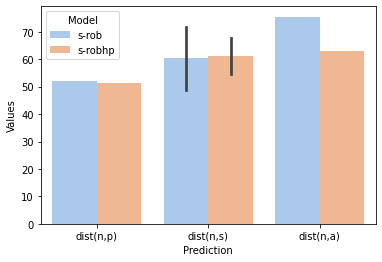

In [62]:
sns.barplot(x = "Prediction", y = "Values", hue = "Model", data = df)

In [23]:
df[(df['Model']=='s-rob')&(df['Prop']=='p-s')]

,Values,Model,Prediction,Prop
0,52.07,s-rob,"dist(n,p)",p-s
2,48.73,s-rob,"dist(n,s)",p-s


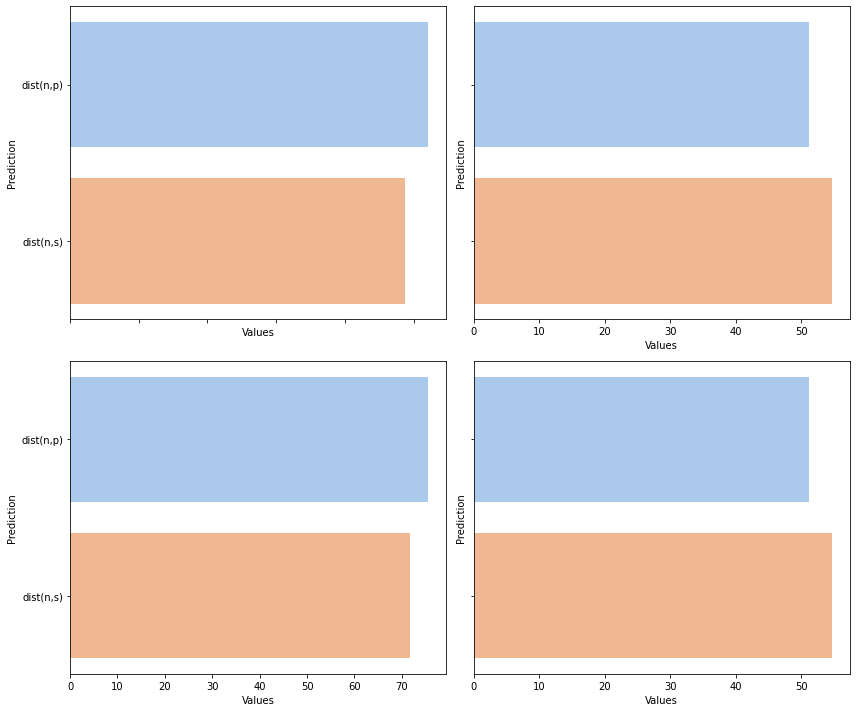

In [63]:
sns.set_palette("pastel",3)

fig, ax = plt.subplots(2,2, figsize=(12,10), sharey=True,
                       gridspec_kw=dict(width_ratios=[0.5,0.5]))
# ax[0][0].set_ylabel('')    
# ax[0][1].set_ylabel('')    
# ax[1][0].set_ylabel('')    
# ax[1][1].set_ylabel('')    

ax[0][0] = sns.barplot(x="Values", y="Prediction", data=df[(df['Model']=='s-rob')&(df['Prop']=='p-s')], ax=ax[0][0])
ax[0][1] = sns.barplot(x="Values", y="Prediction", data=df[(df['Model']=='s-robhp')&(df['Prop']=='p-s')], ax=ax[0][1])
ax[1][0] = sns.barplot(x="Values", y="Prediction", data=df[(df['Model']=='s-rob')&(df['Prop']=='a-s')], ax=ax[1][0])
ax[1][1] = sns.barplot(x="Values", y="Prediction", data=df[(df['Model']=='s-robhp')&(df['Prop']=='p-s')], ax=ax[1][1])

plt.setp(ax[0][0].get_xticklabels(), visible=False)
#plt.setp(ax[0][0].get_xlabels(), visible=False)

fig.tight_layout()
fig.savefig("bars.png",dpi=400) 
